<h2>Anomaly Detection</h2>

In this module, we discuss the anomaly detection task. This is a unsupervised learning task - which means we do not use labels (targets) when training anomaly detection models. 

The data for this task is the daily ETF SPY share prices from 1993 until this March. For each day, we have the Open, Close, Adjusted Close, High, Low prices, and the volume. We will use the Open, Close, High, and Low features for this module. The task is to detect days with anomalous movements of prices.

<h3>Loading and Visualizing the Data</h3>

In [1]:
%matplotlib notebook 

#this is call a "magic command" in Jupyter notebook. This command allows matplotlib figures to be interactive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spy = pd.read_csv('SPY.csv')
spy['Date'] = pd.to_datetime(spy['Date'])
spy

Date        Open        High         Low       Close   Adj Close  \
0    1993-01-29   43.968750   43.968750   43.750000   43.937500   25.627340   
1    1993-02-01   43.968750   44.250000   43.968750   44.250000   25.809614   
2    1993-02-02   44.218750   44.375000   44.125000   44.343750   25.864302   
3    1993-02-03   44.406250   44.843750   44.375000   44.812500   26.137711   
4    1993-02-04   44.968750   45.093750   44.468750   45.000000   26.247076   
...         ...         ...         ...         ...         ...         ...   
7326 2022-03-03  440.470001  441.109985  433.799988  435.709991  435.709991   
7327 2022-03-04  431.750000  433.369995  427.880005  432.170013  432.170013   
7328 2022-03-07  431.549988  432.299988  419.359985  419.429993  419.429993   
7329 2022-03-08  419.619995  427.209991  415.119995  416.250000  416.250000   
7330 2022-03-09  425.140015  429.510010  422.820007  427.410004  427.410004   

         Volume  
0       1003200  
1        480500  
2        201300  
3        529400  
4        531500  
...         ...  
7326  105501700  
7327  113978200  
7328  137501700  
7329  164334600  
7330  116990765  

[7331 rows x 7 columns]

Plot the four features side-by-side. The y-axis represents the price, and the x-axis represents the date

<IPython.core.display.Javascript object>


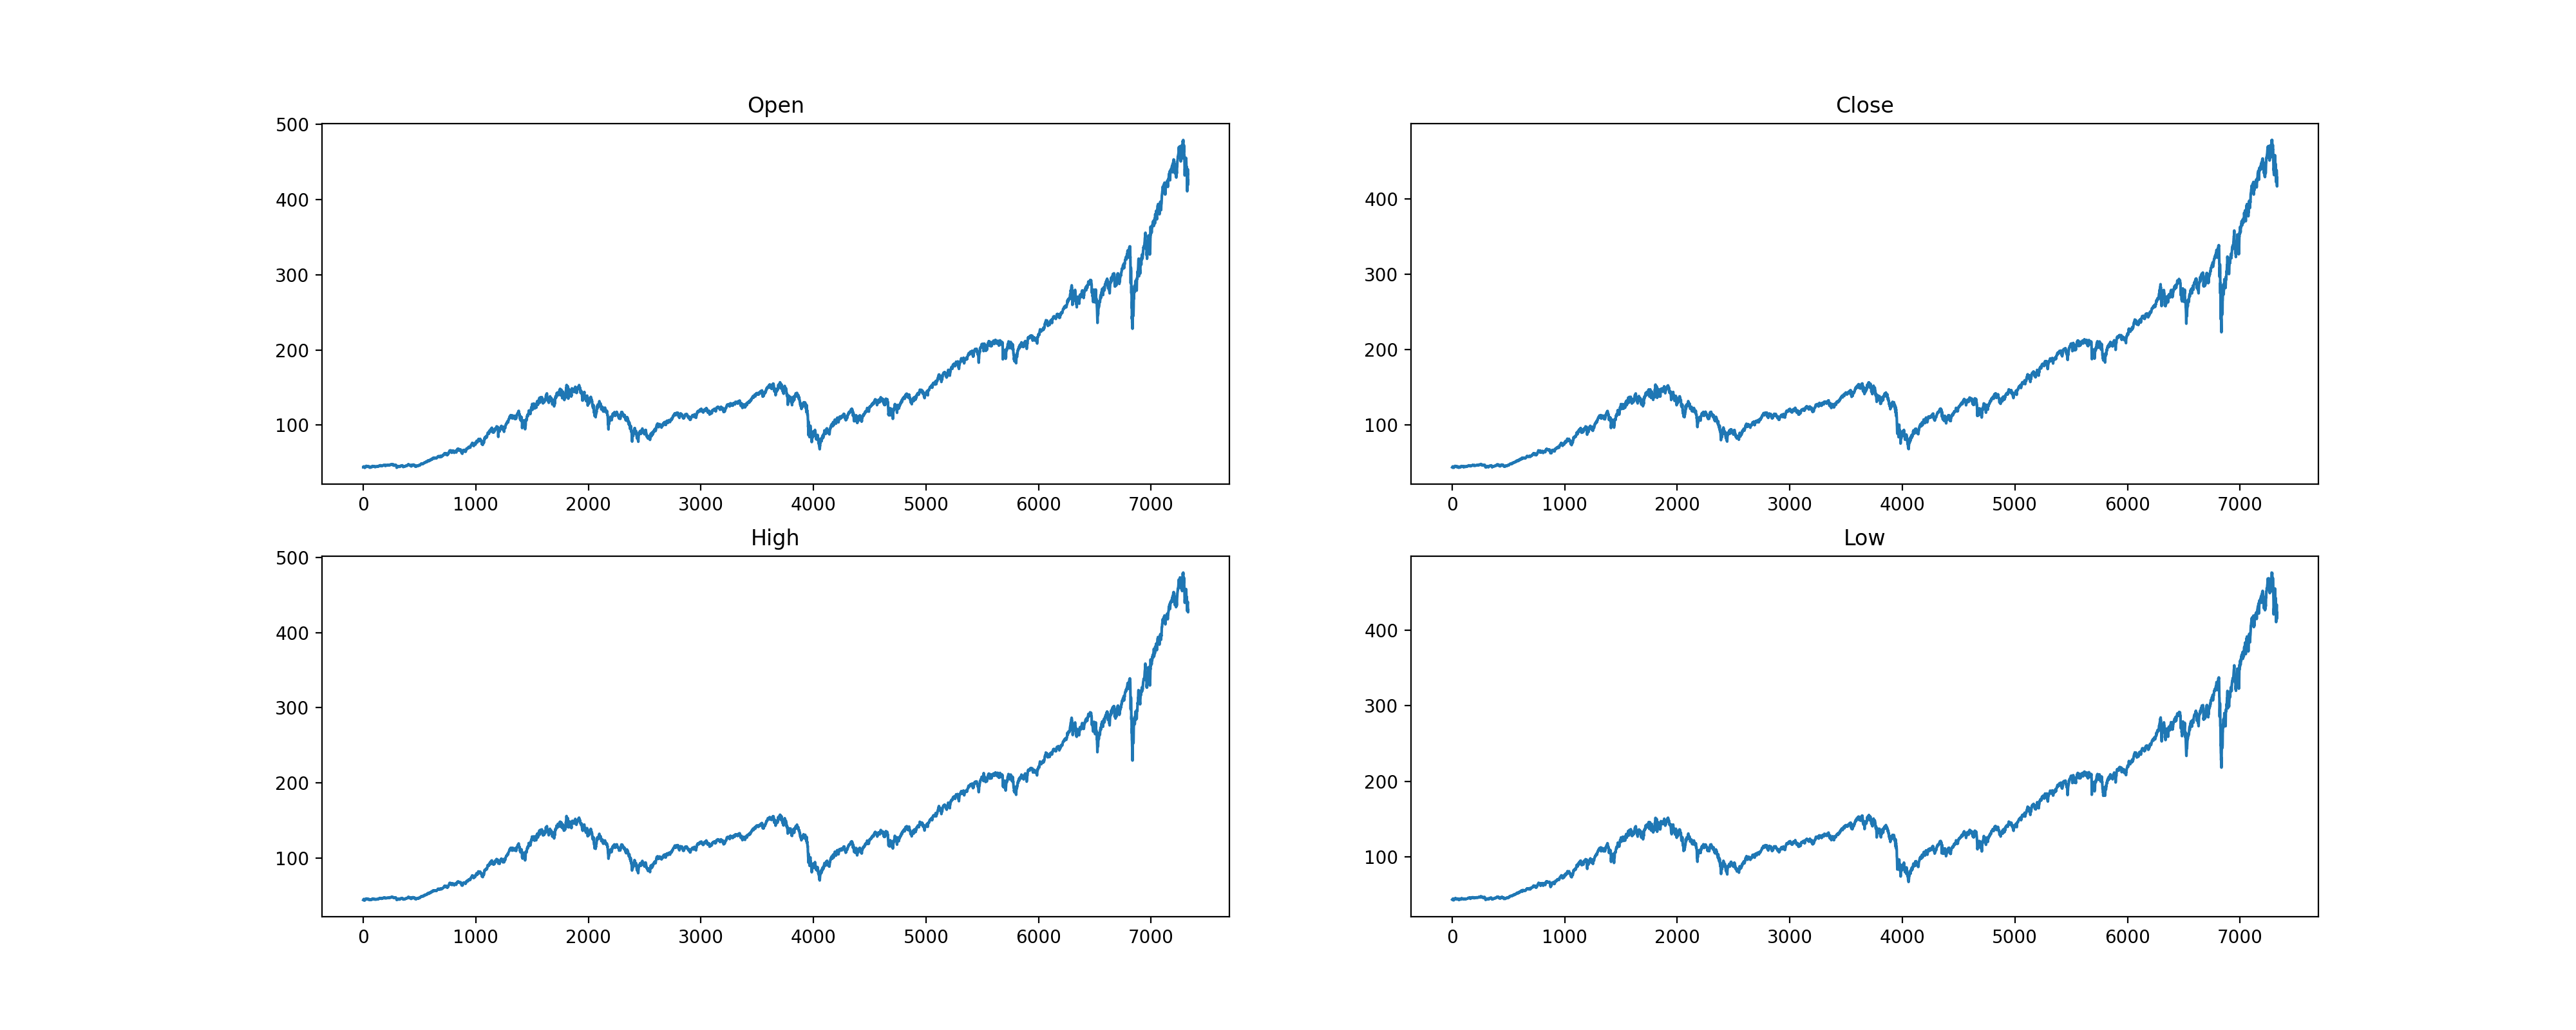

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
axs[0, 0].plot(spy['Open'])
axs[0, 0].set_title('Open')
axs[0, 1].plot(spy['Close'])
axs[0, 1].set_title('Close')
axs[1, 0].plot(spy['High'])
axs[1, 0].set_title('High')
axs[1, 1].plot(spy['Low'])
axs[1, 1].set_title('Low')
plt.show()

We can also use a candlestick plot to illustrate stock data. This type of plot allows representing all four features (Open, Close, High, and Low) in a single plot.

<IPython.core.display.Javascript object>


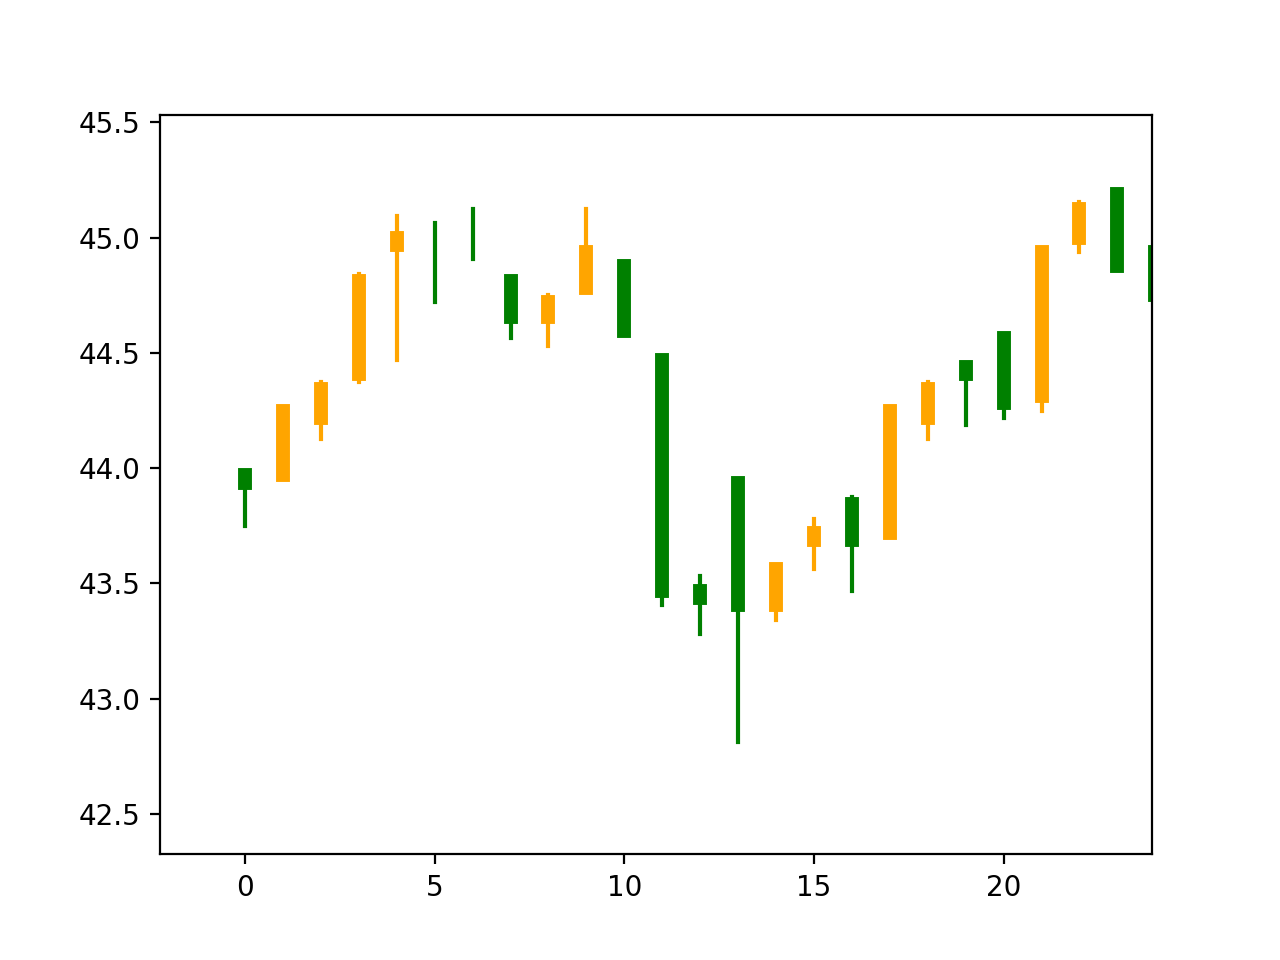

In [64]:
for d in range(spy.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    plt.plot([d,d],[spy['High'][d],spy['Low'][d]],color=c)
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<h3>Modeling Using Only Open and Close</h3>

For demonstration purpose, we first start using only two features. This allows us to plot the instances in a scatter plot and view how the anomalies are different from regular instances.

In [3]:
X = spy[['Open','Close']].values
X.shape

(7331, 2)

<h4>One-Class Support Vector Machine</h4>

In [69]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(kernel='rbf',gamma=0.001,nu=0.01).fit(X)
y_ocsvm = ocsvm.predict(X)
np.unique(y_ocsvm, return_counts=True)

(array([-1,  1], dtype=int64), array([  74, 7257], dtype=int64))

<IPython.core.display.Javascript object>


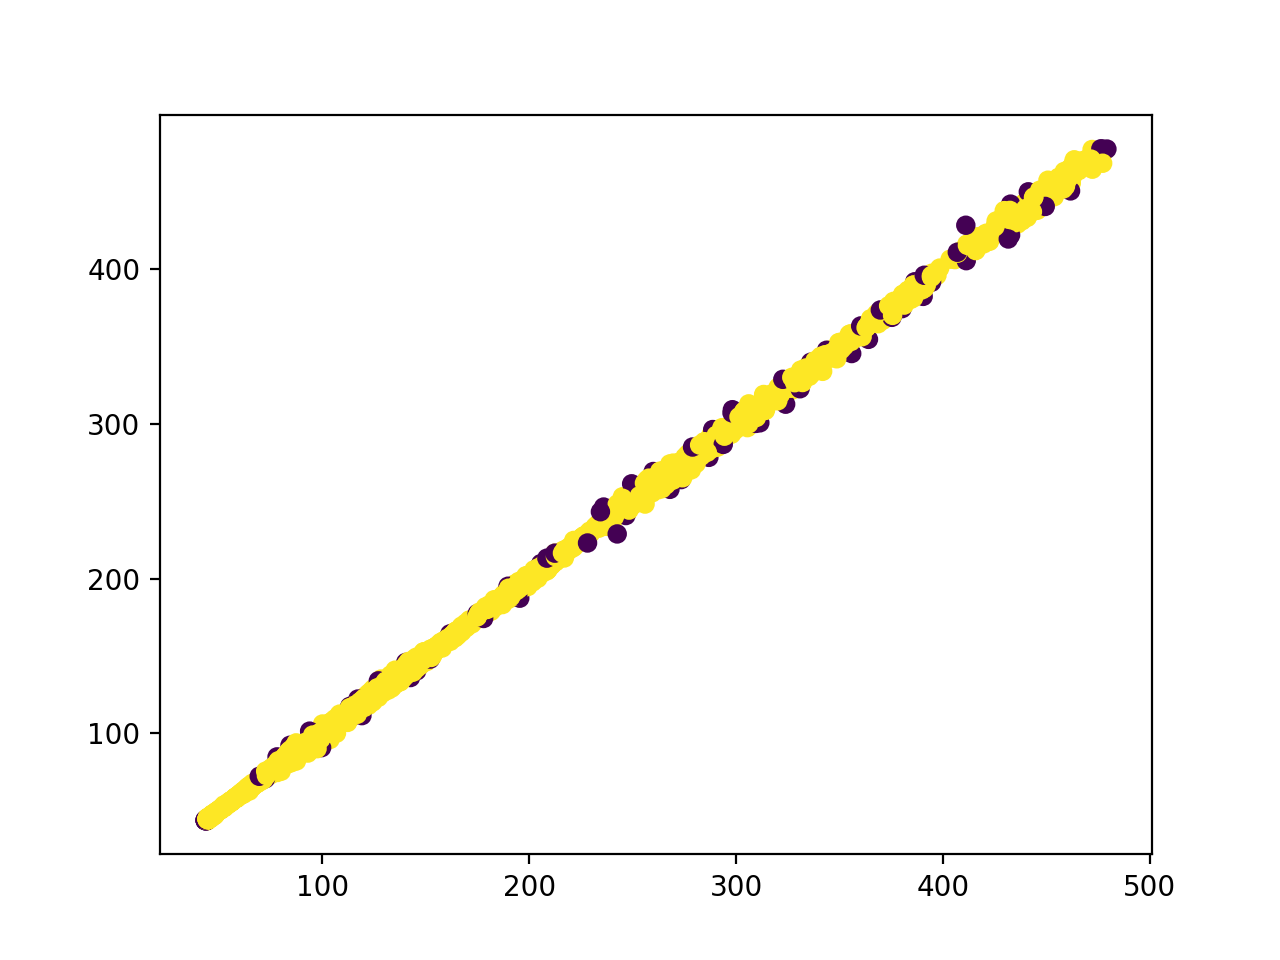

In [75]:
plt.scatter(X[:,0],X[:,1],c=y_ocsvm)
plt.show()

<IPython.core.display.Javascript object>


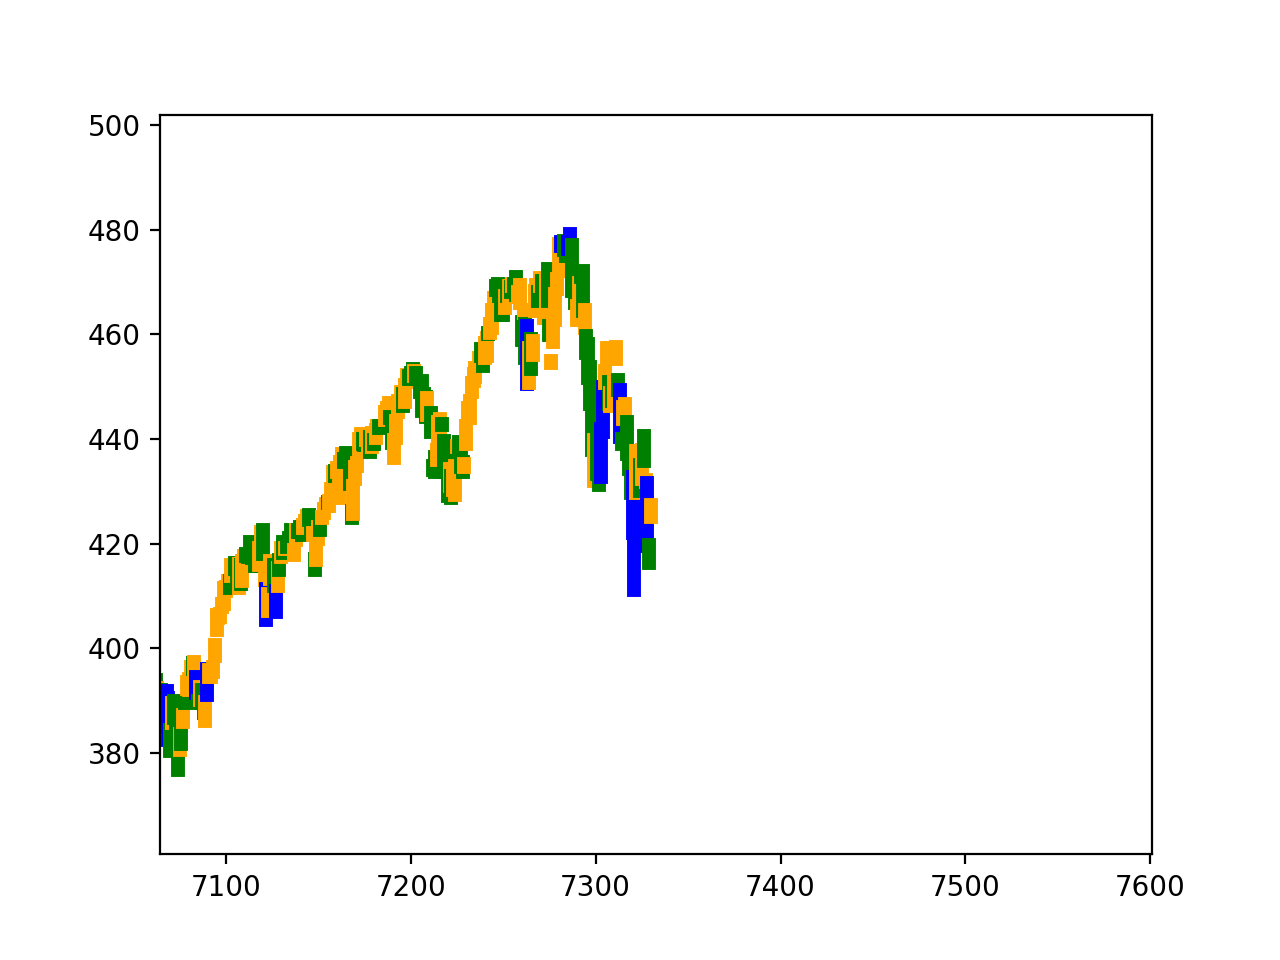

In [72]:
for d in range(spy.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_ocsvm[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<h4>Isolation Forest</h4>

In [5]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, contamination=0.01).fit(X)
y_if = clf.predict(X)

<IPython.core.display.Javascript object>


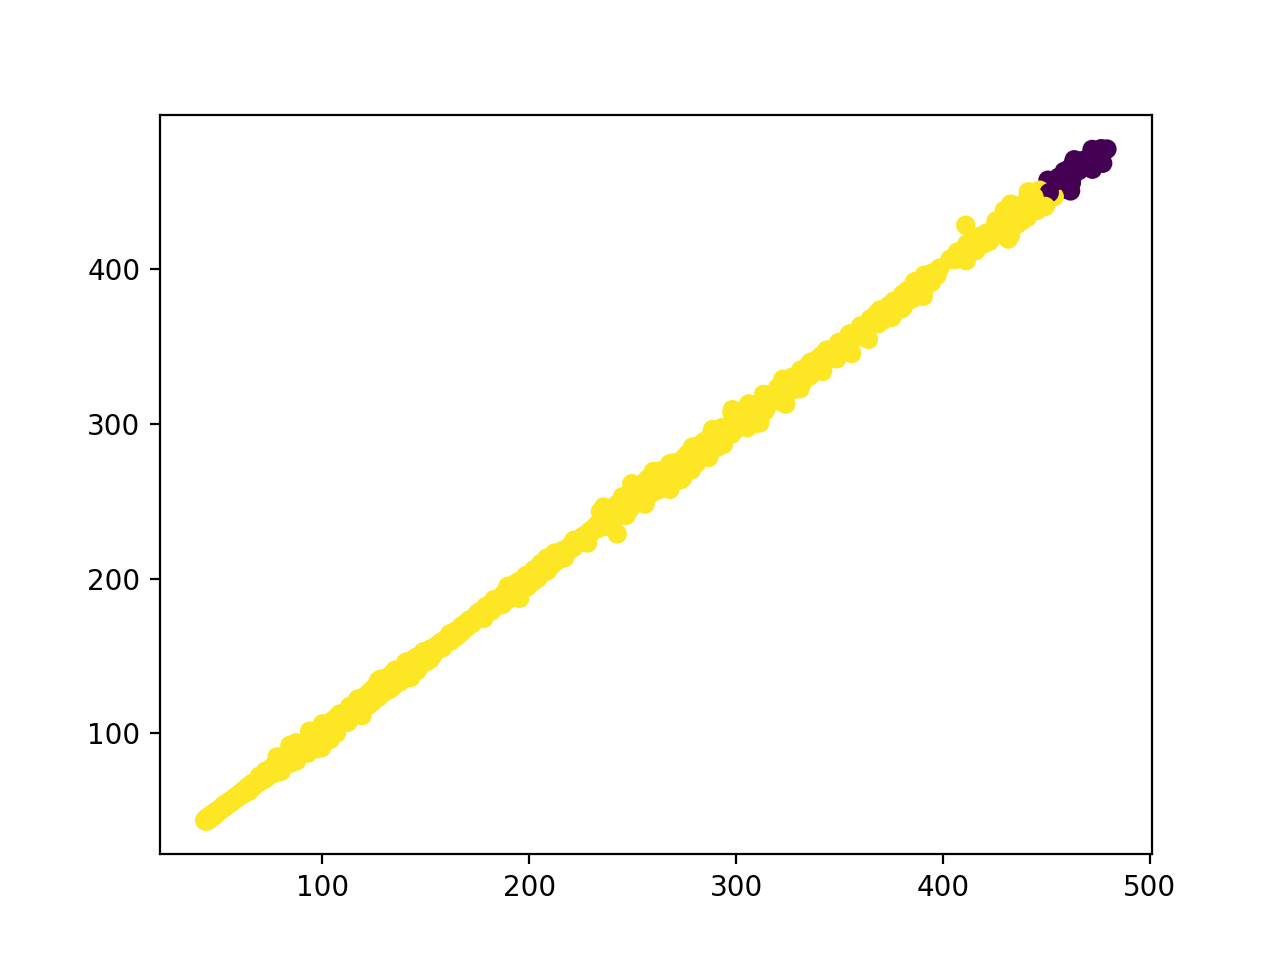

In [6]:
plt.scatter(X[:,0],X[:,1],c=y_if)
plt.show()

<IPython.core.display.Javascript object>


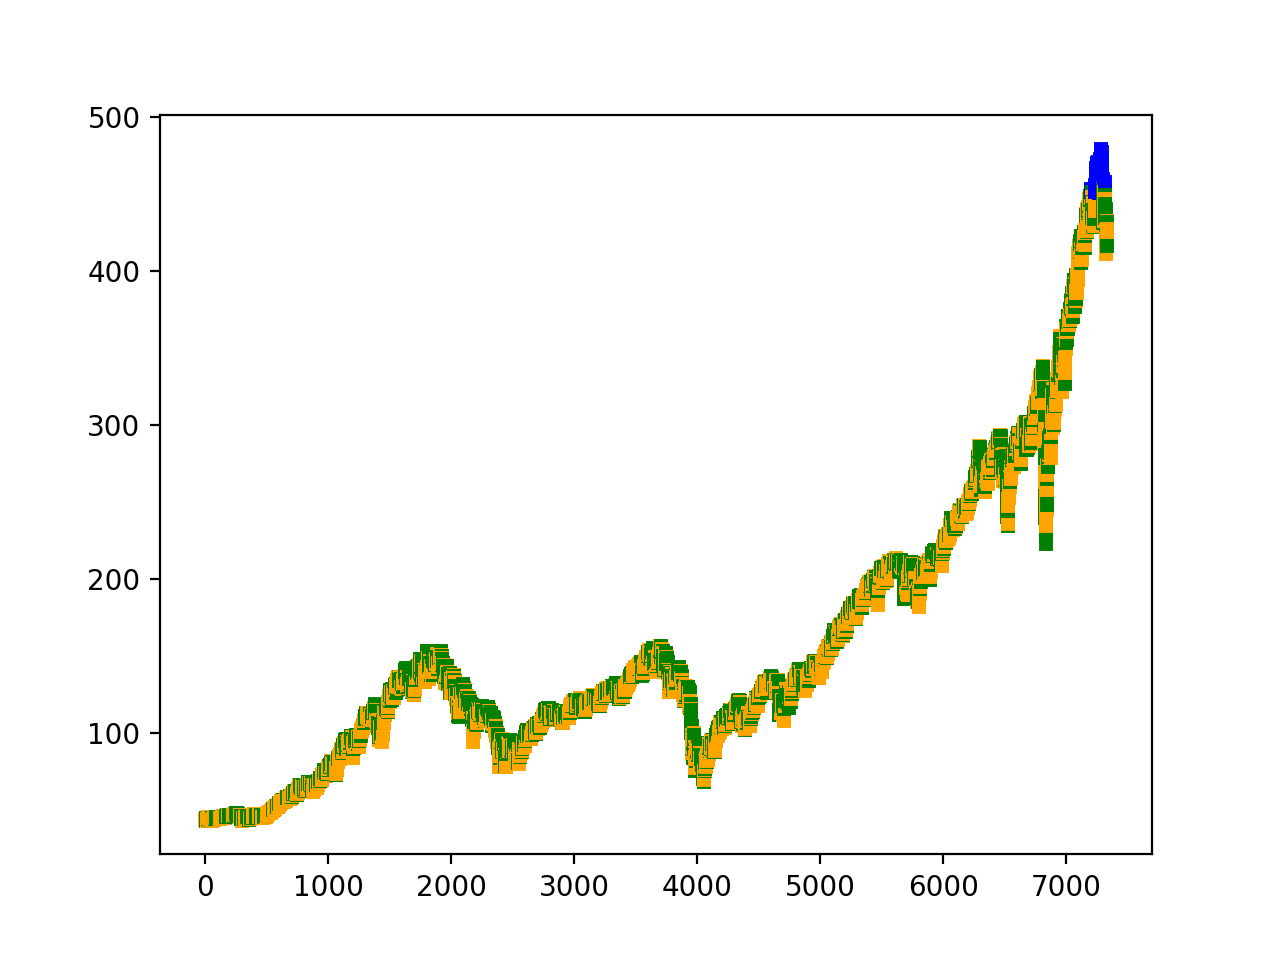

In [17]:
for d in range(spy.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_if[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<h4>Local Outlier Factor</h4>

In [89]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=50)
y_lof = lof.fit_predict(X)

<IPython.core.display.Javascript object>


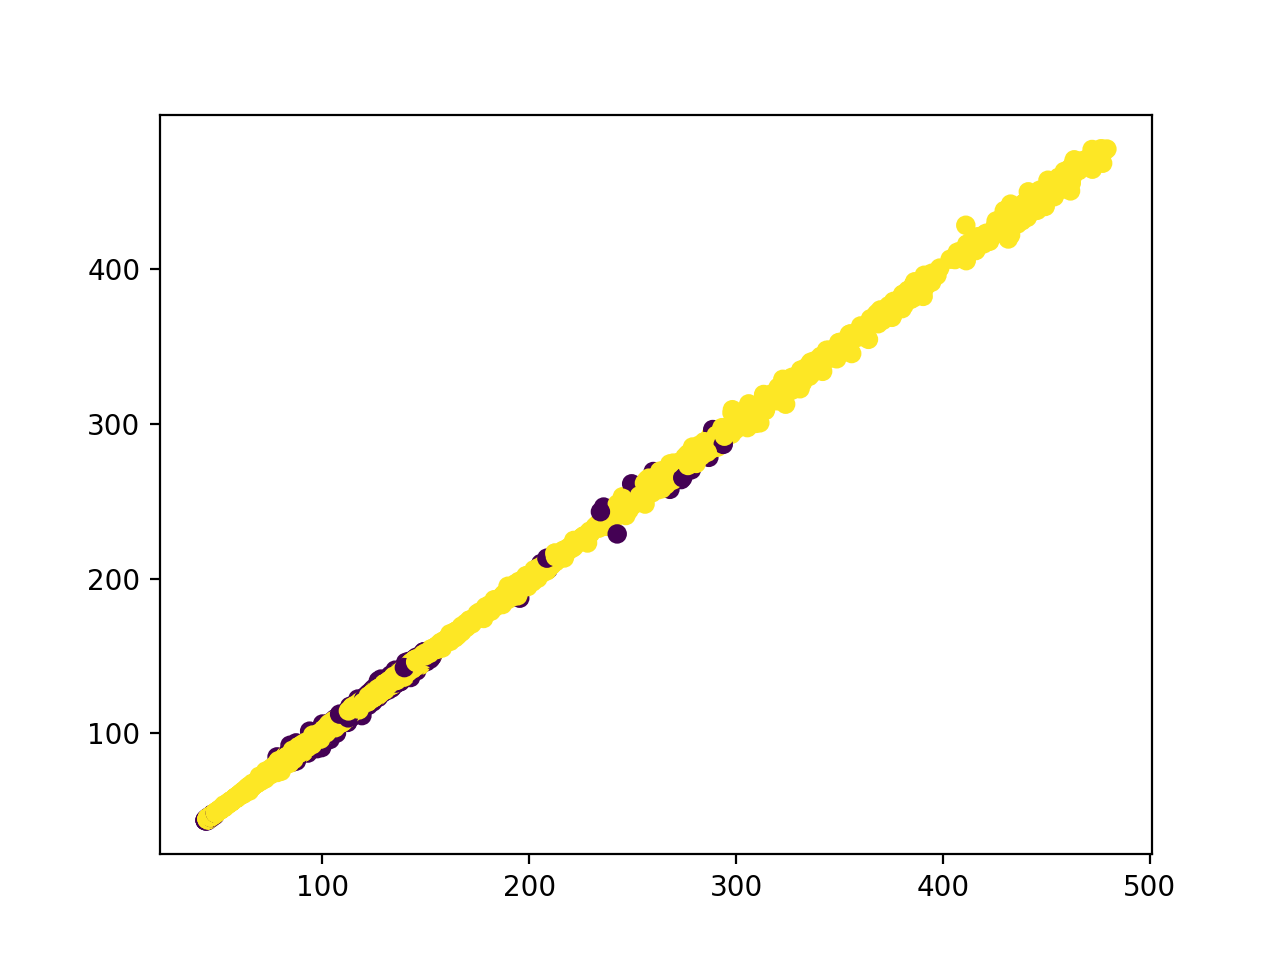

In [90]:
plt.scatter(X[:,0],X[:,1],c=y_lof)
plt.show()

<IPython.core.display.Javascript object>


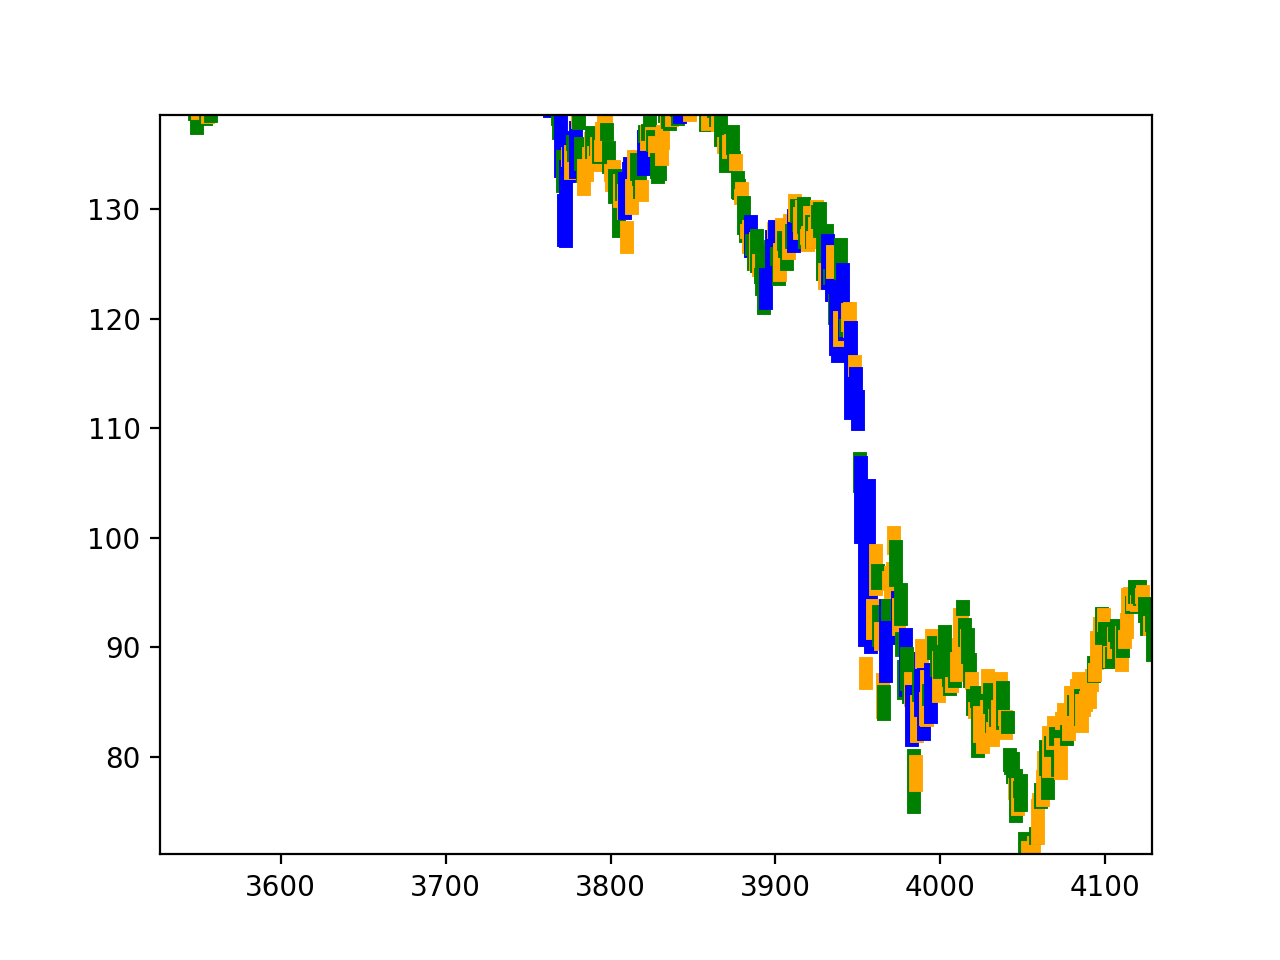

In [91]:
for d in range(spy.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_lof[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<h3>Modeling by Daily Differences</h3>

For data like the SPY ETF, we can see sometimes the instances are strongly correlated to time -- prices at the beginning of the ETF are much lower than prices at the end. This may cause issues to certain models, for example, isolation forest, as we can see earlier. Unfortunately, standardization does not solve this issue since the data is only rescale, and their differences through times are still the same. 

One way of solving this problem is to "difference" the data. Instead of modeling with the actual daily prices, we model with the <b>changes in prices</b> (applied to all Open, Close, High, Low). As below, the differenced data is having a much better distribution than the original data.

In [12]:
X_diff = np.diff(X,axis=0)
X_diff.shape

(7330, 2)

<IPython.core.display.Javascript object>


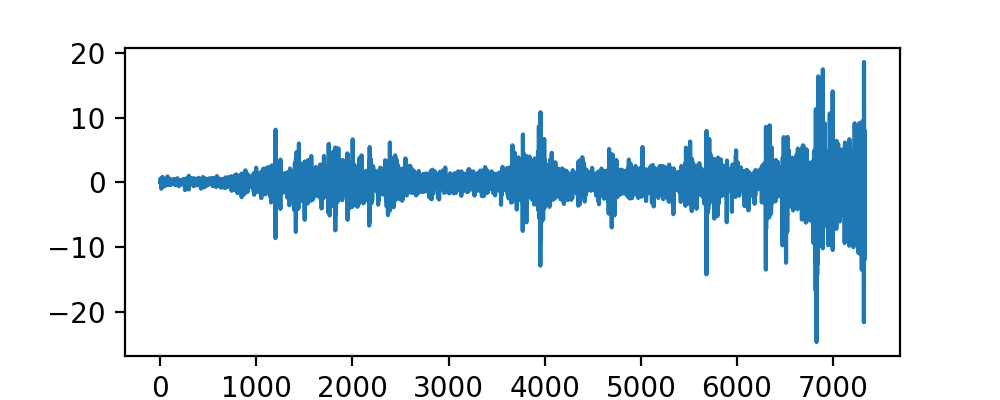

<IPython.core.display.Javascript object>


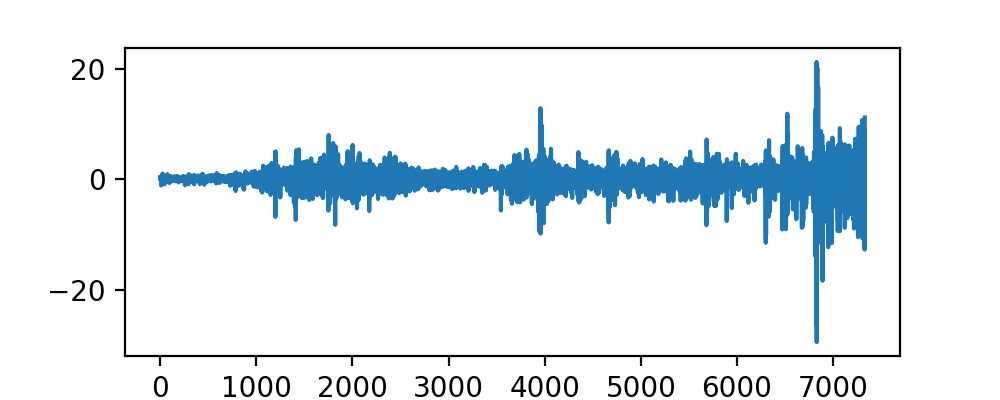

In [23]:
for col in [0,1]:
    plt.figure(figsize=(5,2))
    plt.plot(X_diff[:,col])
    plt.show()

In [79]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(gamma=0.001,nu=0.01).fit(X_diff)
y_ocsvm = ocsvm.predict(X_diff)
np.unique(y_ocsvm, return_counts=True)

(array([-1,  1]), array([  72, 7258]))

<IPython.core.display.Javascript object>


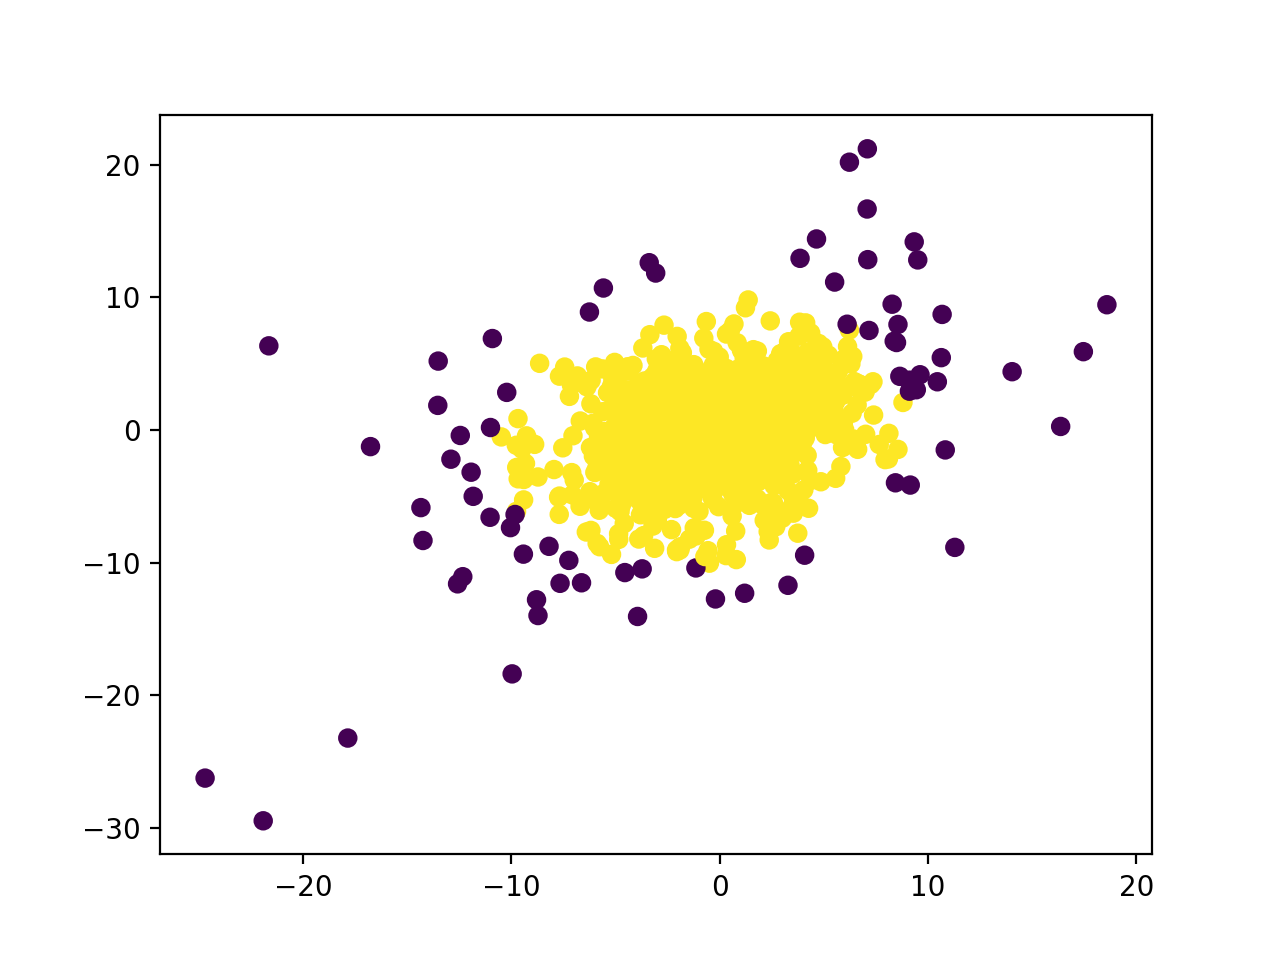

In [25]:
plt.scatter(X_diff[:,0],X_diff[:,1],c=y_ocsvm)
plt.show()

<IPython.core.display.Javascript object>


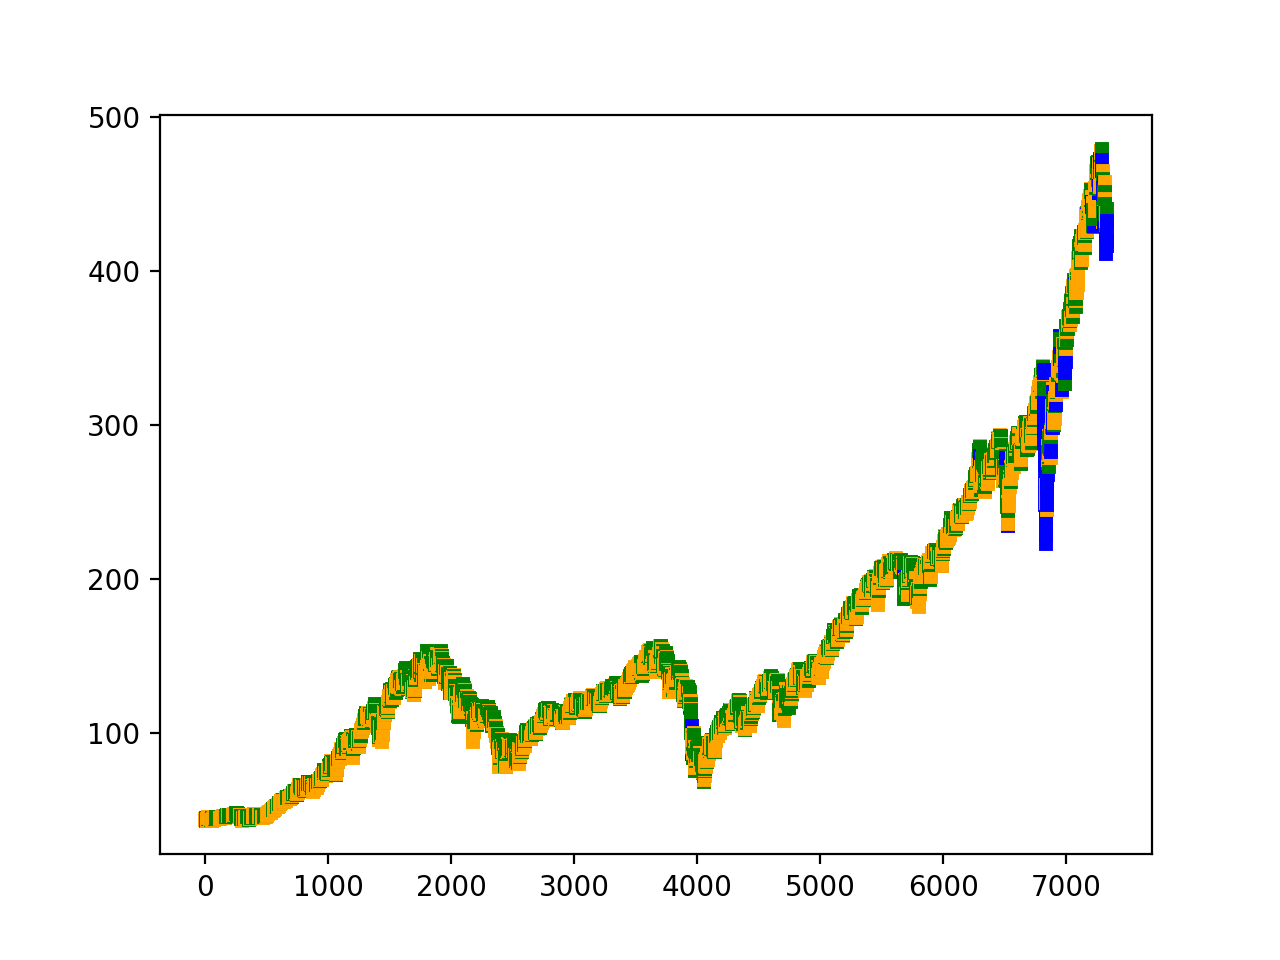

In [26]:
for d in range(X_diff.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_ocsvm[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

In [80]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, contamination=0.005).fit(X_diff)
y_if = clf.predict(X_diff)

<IPython.core.display.Javascript object>


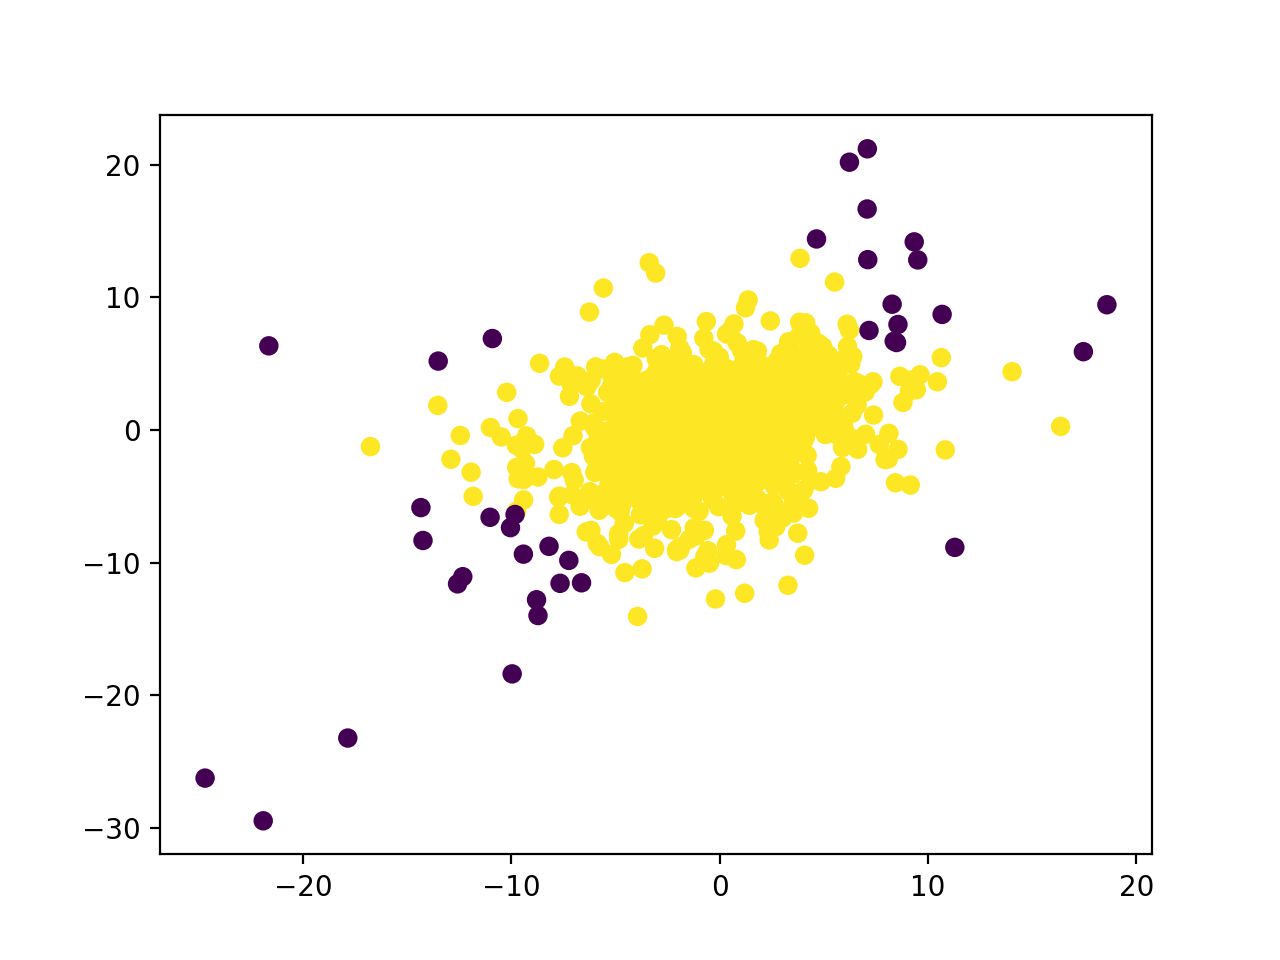

In [28]:
plt.scatter(X_diff[:,0],X_diff[:,1],c=y_if)
plt.show()

<IPython.core.display.Javascript object>


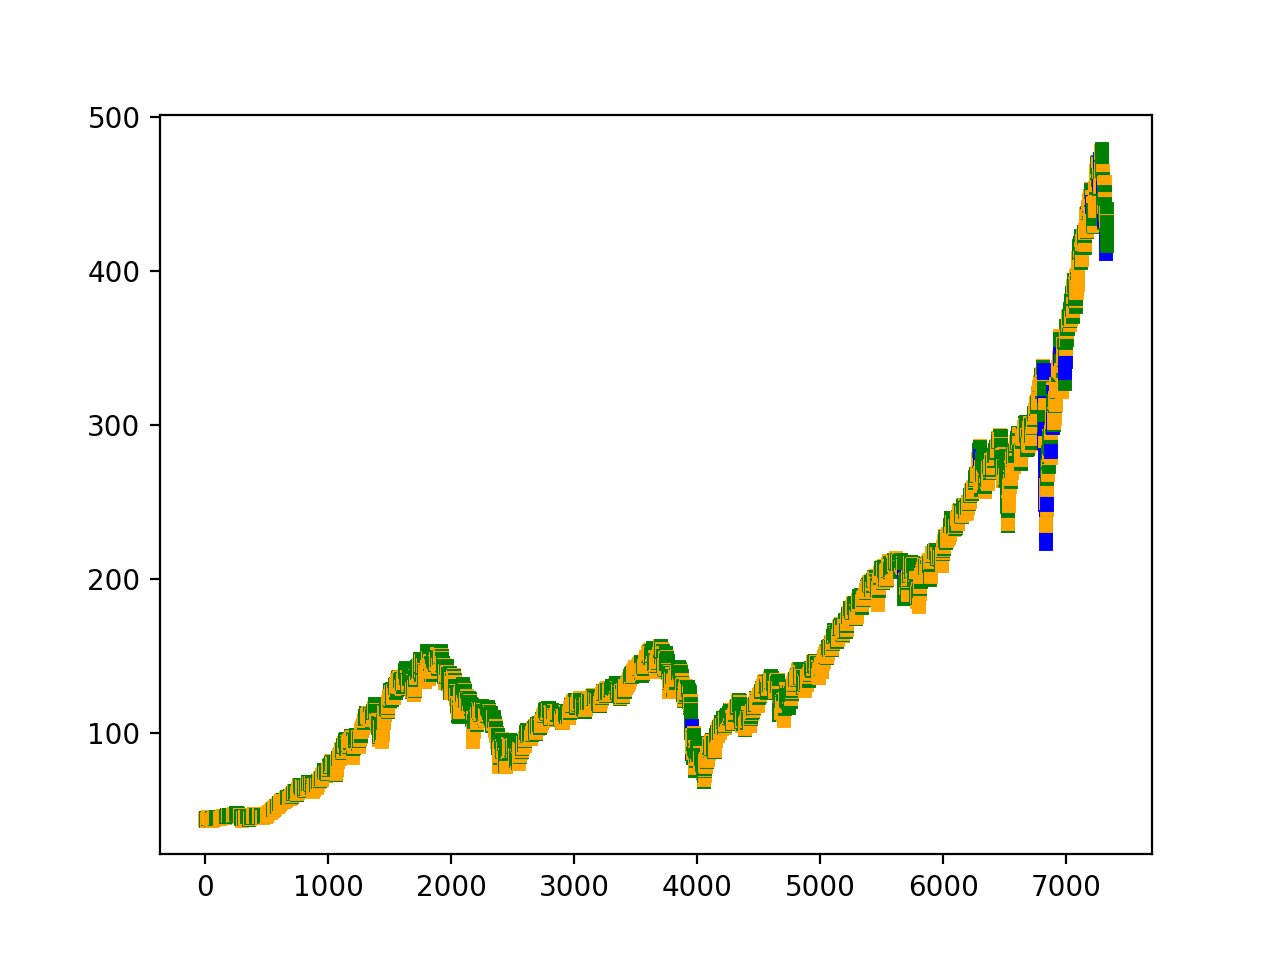

In [29]:
for d in range(X_diff.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_if[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

In [81]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20)
y_lof = lof.fit_predict(X_diff)

<IPython.core.display.Javascript object>


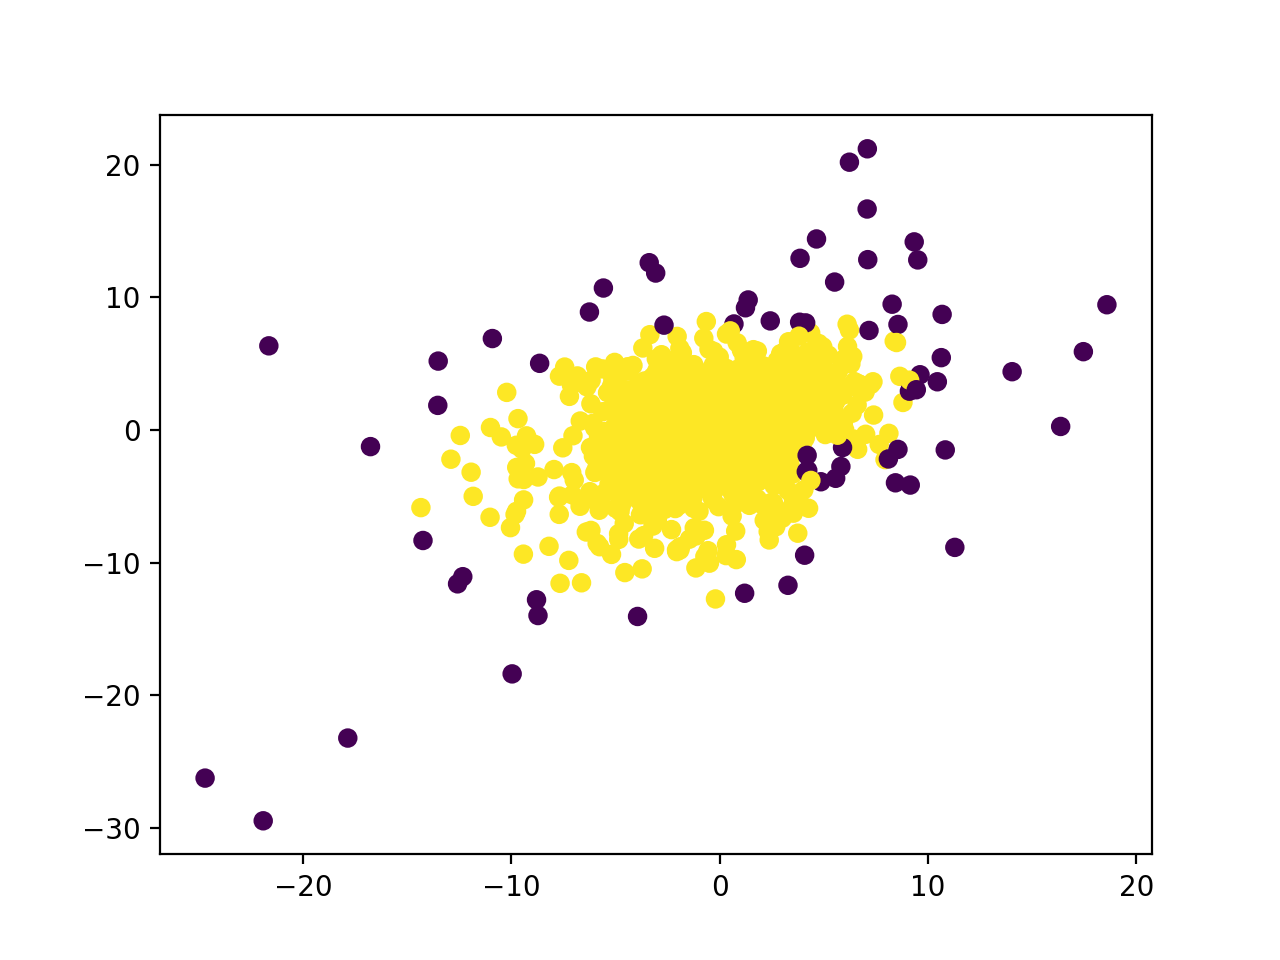

In [31]:
plt.scatter(X_diff[:,0],X_diff[:,1],c=y_lof)
plt.show()

<IPython.core.display.Javascript object>


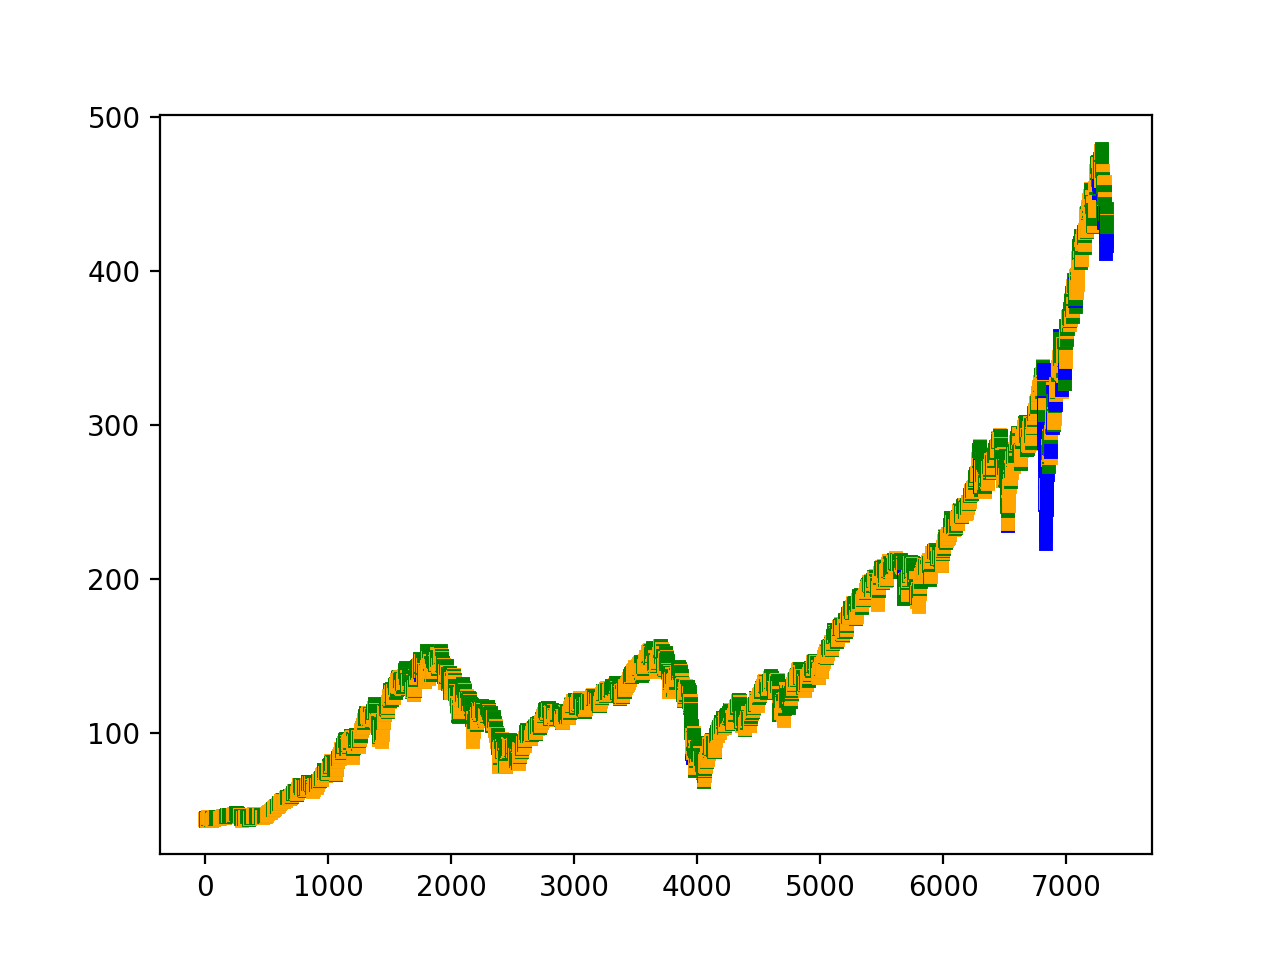

In [32]:
for d in range(X_diff.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_lof[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<h4>AWS Random Cut Forest</h4>

<h5>Setting up Environment</h5>

In [10]:
import sagemaker
import boto3
from time import gmtime, strftime
import os
from sagemaker import get_execution_role

region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')

role = get_execution_role()
print(role)

sess = sagemaker.Session()
bucket = 'lle13bucket1' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
prefix = 'DEMO-automatic-model-tuning-xgboost-dm'

arn:aws:iam::055003053546:role/service-role/AmazonSageMaker-ExecutionRole-20220213T111622


<h5>Create Model</h5>

In [27]:
from sagemaker import RandomCutForest

# specify general training job information
rcf = RandomCutForest(
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

<h5>Training the Model</h5>

In [28]:
rcf.fit(rcf.record_set(X_diff))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-03-15 20:40:25 Starting - Starting the training job...ProfilerReport-1647376825: InProgress
...
2022-03-15 20:41:24 Starting - Preparing the instances for training.........
2022-03-15 20:42:47 Downloading - Downloading input data...
2022-03-15 20:43:26 Training - Downloading the training image......
2022-03-15 20:44:26 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/15/2022 20:44:30 INFO 139913133717312 integration.py:636] worker started
[03/15/2022 20:44:30 INFO 139913133717312] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_obj

<h5>Making Prediction and Visualize the Results</h5>

In [29]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
results = rcf_inference.predict(X_diff)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------!

In [69]:
scores = np.array([d.label['score'].float32_tensor.values for d in results]).flatten()
score_mean = np.mean(scores)
score_std = np.std(scores)

score_cutoff = score_mean + 3.5*score_std
anomalies = np.ones(X_diff.shape[0])
anomalies[scores > score_cutoff] = -1

<IPython.core.display.Javascript object>


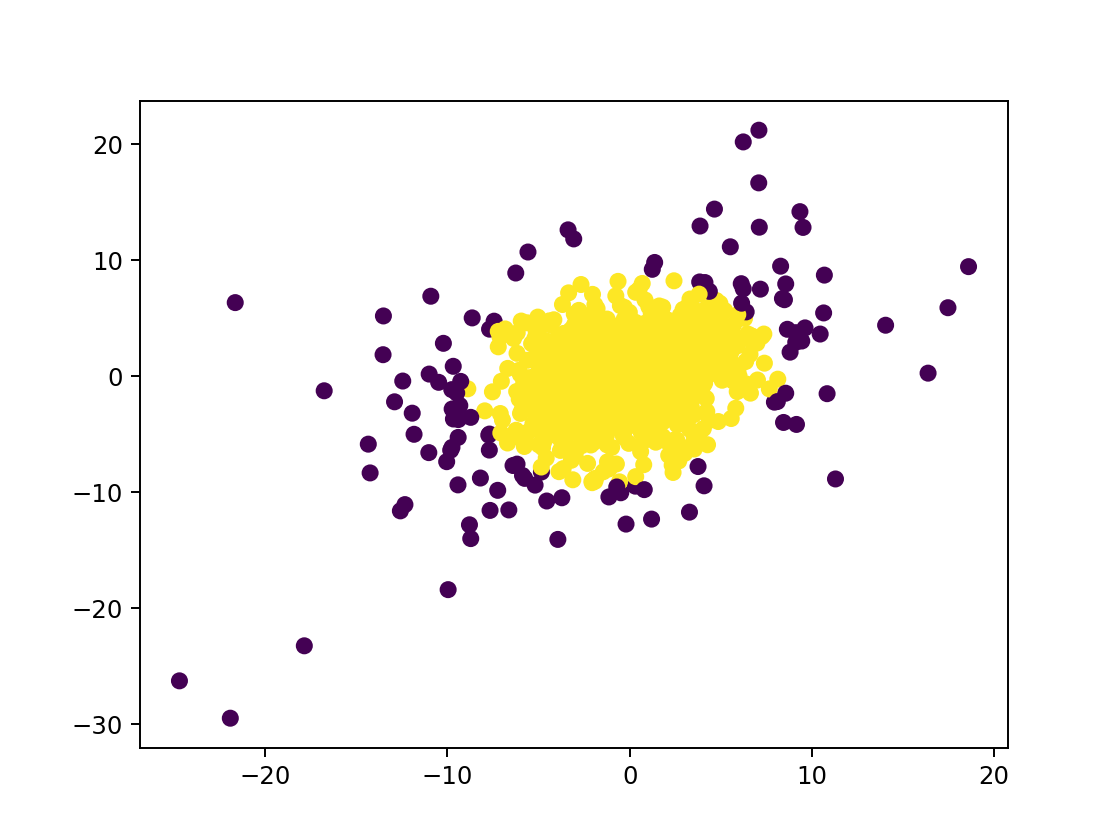

In [70]:
plt.scatter(X_diff[:,0],X_diff[:,1],c=anomalies)
plt.show()

<IPython.core.display.Javascript object>


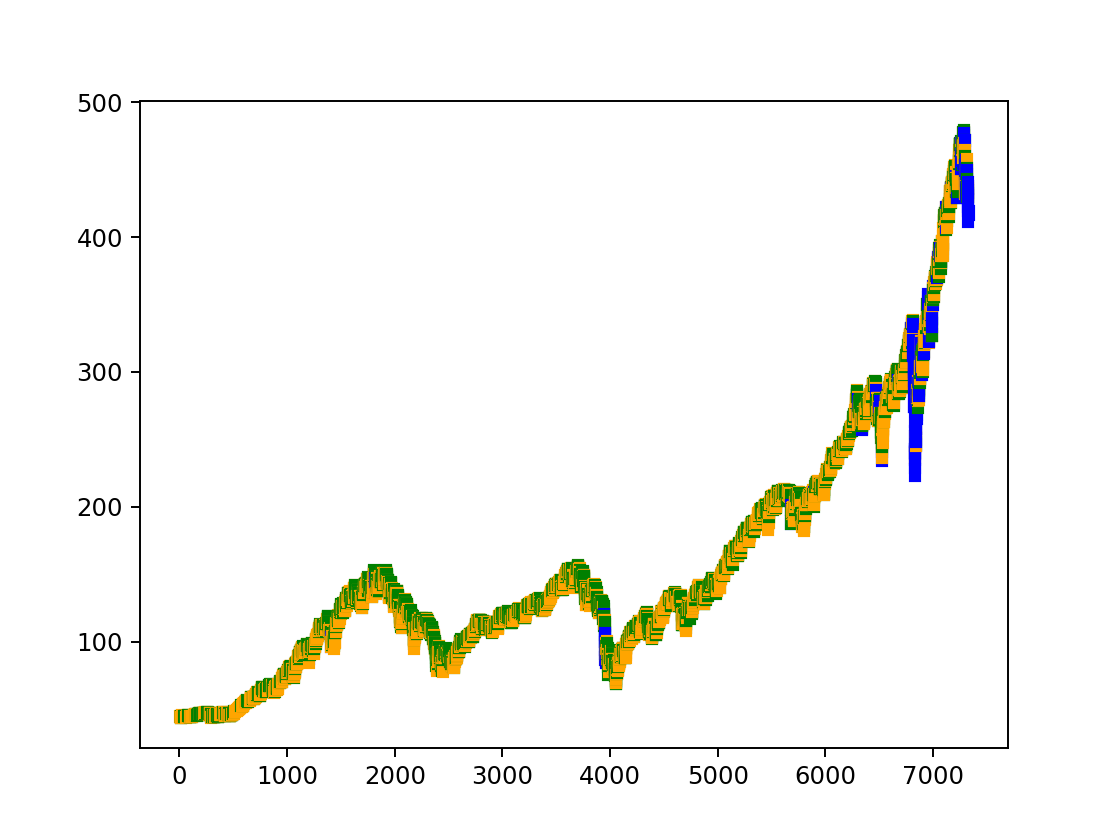

In [71]:
for d in range(X_diff.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if anomalies[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<h5>Cleaning up</h5>

In [74]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '5637S6X4CZ46EZ87',
   'HostId': 'ApK9hDI5fQbiaXwvEqzLSUzimcq3ML3A91KkqXI+qKSdtbzWM8HNdfxK+giJf8PLS10wJAuDobE=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'ApK9hDI5fQbiaXwvEqzLSUzimcq3ML3A91KkqXI+qKSdtbzWM8HNdfxK+giJf8PLS10wJAuDobE=',
    'x-amz-request-id': '5637S6X4CZ46EZ87',
    'date': 'Tue, 15 Mar 2022 21:16:55 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-02-14-04-59-35-663/profiler-output/framework/training_job_end.ts'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-02-14-04-59-35-663/profiler-output/system/incremental/2022021405/1644814920.algo-1.json'},
   {'Key': 'sagemaker/DEMO-xgboost-dm/output/xgboost-2022-02-14-04-59-35-663/rule-output/ProfilerReport-1644814775/profiler-output/profiler-reports/GPUMemoryIncrease.json'},
   {'Key':

<h5>Comparing Anomalies Detected from All Models</h5>

In [82]:
y_ocsvm.shape, y_if.shape, y_lof.shape, anomalies.shape

((7330,), (7330,), (7330,), (7330,))

In [91]:
true_ano = ((y_ocsvm == -1) & (y_if == -1) & (y_lof == -1) & (anomalies == -1))*1

<IPython.core.display.Javascript object>


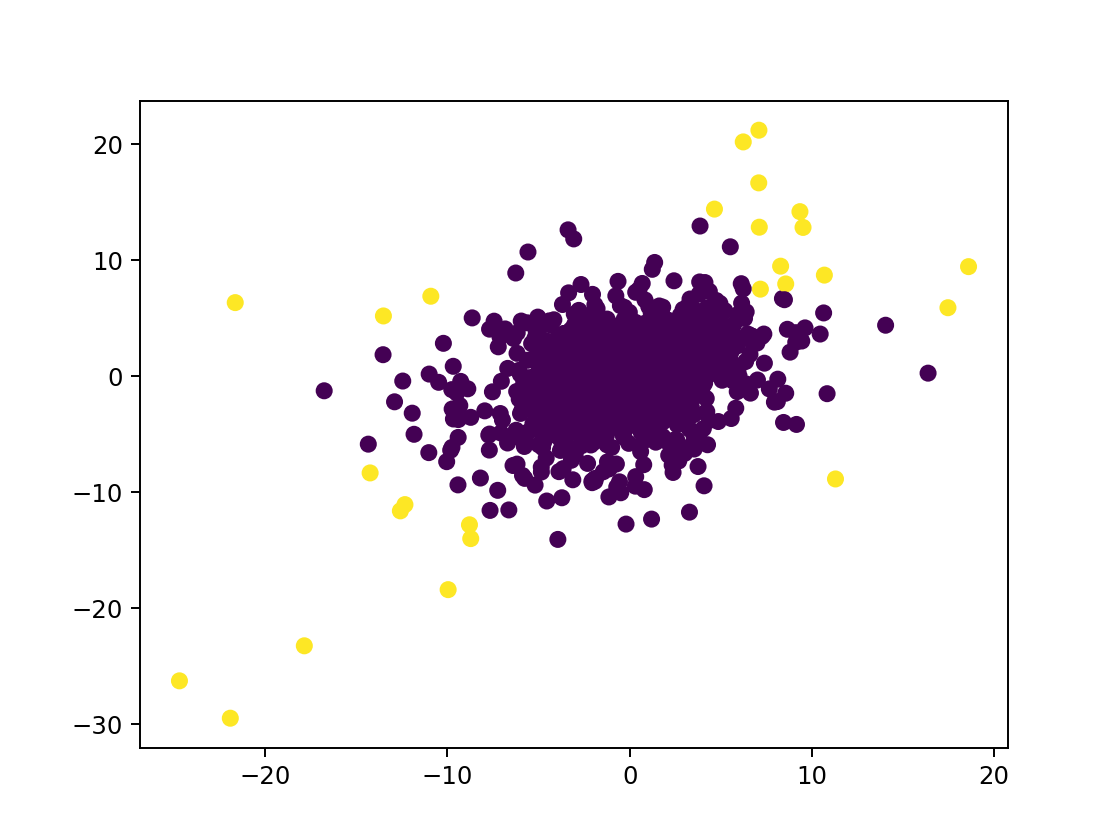

In [93]:
plt.scatter(X_diff[:,0],X_diff[:,1],c=true_ano)
plt.show()

<IPython.core.display.Javascript object>


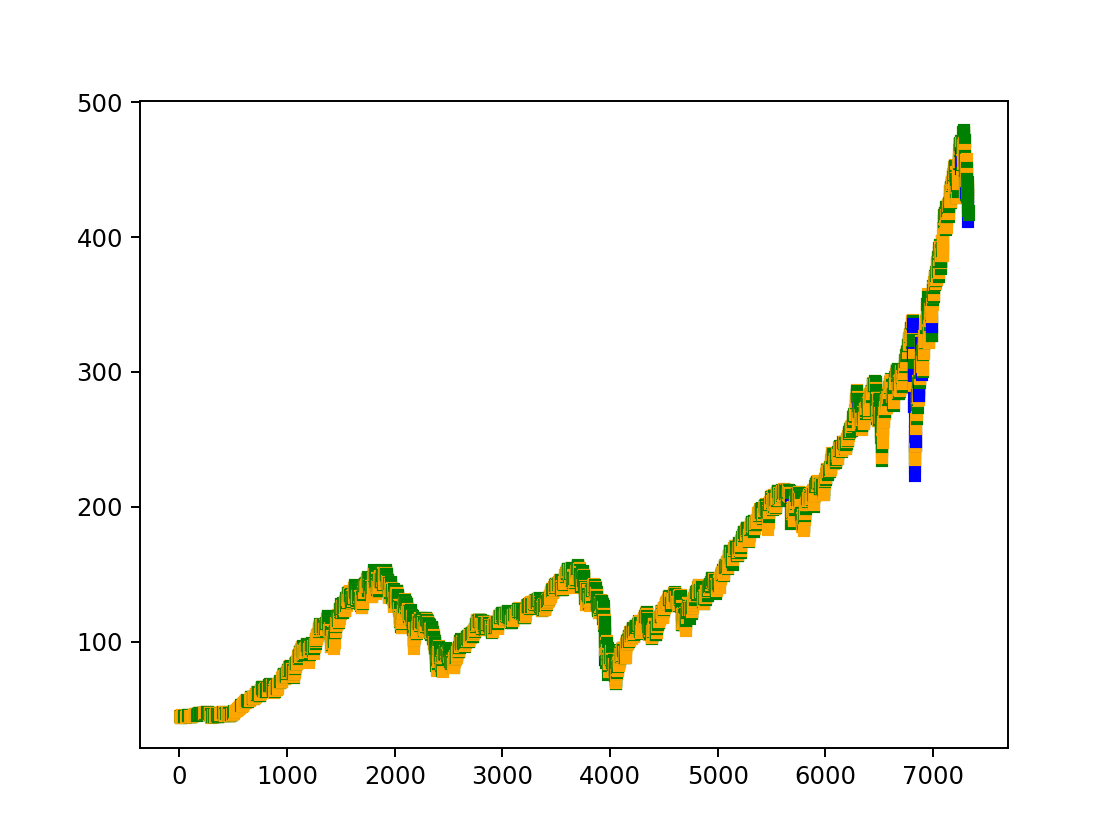

In [94]:
for d in range(X_diff.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if true_ano[d] == 1:
        c = 'blue'
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<h3>More In-Depth Analysis: Using All Available Features</h3>

Now we use all available features and perform the same analysis.

In [4]:
X = spy[['Open','Close','High','Low']].values

<h4>Visualizing High Dimensional Data with Principal Component Analysis</h4>

As we include four features in the data now, we cannot visualize the original data using a 2D scatter plot anymore. Instead, we can use the Principal Component Analysis (PCA) method to reduce the dimensionality of the data to two. The new dimensions will not have the same meanings as the original ones, however, we can now visualize the data using 2D scatter plots again. There are other methods to reduce the dimensionality of data available in sklearn such as kernel PCA, T-SNE, etc. They are very similar to PCA in terms of usages.

We can see that the scatter plot using PCA is significantly different from the one using Open and Close.

In [41]:
from sklearn.decomposition import PCA

pca = PCA(2)
X2d = pca.fit_transform(X)

<IPython.core.display.Javascript object>


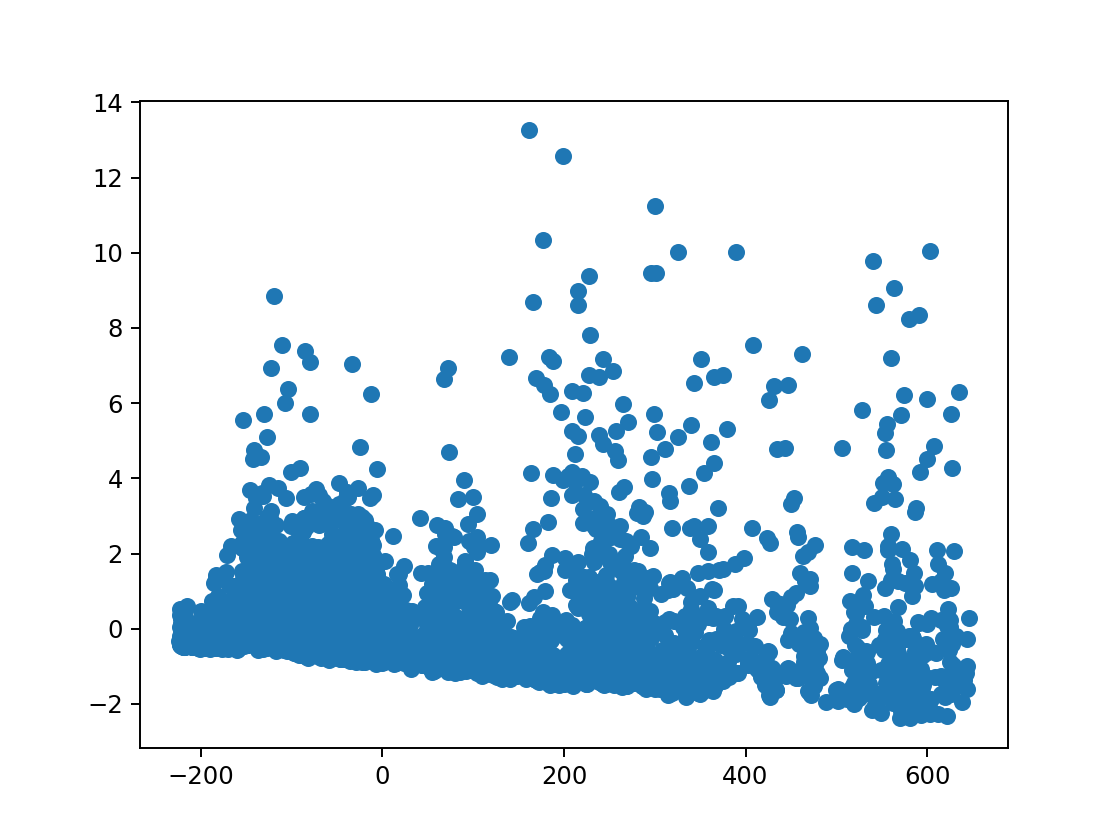

In [42]:
plt.scatter(X2d[:,0], X2d[:,1])
plt.show()

<h4>Modeling</h4>

In [44]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(gamma=0.001,nu=0.01).fit(X)
y_ocsvm = ocsvm.predict(X)
np.unique(y_ocsvm, return_counts=True)

(array([-1,  1], dtype=int64), array([  80, 7251], dtype=int64))

<IPython.core.display.Javascript object>


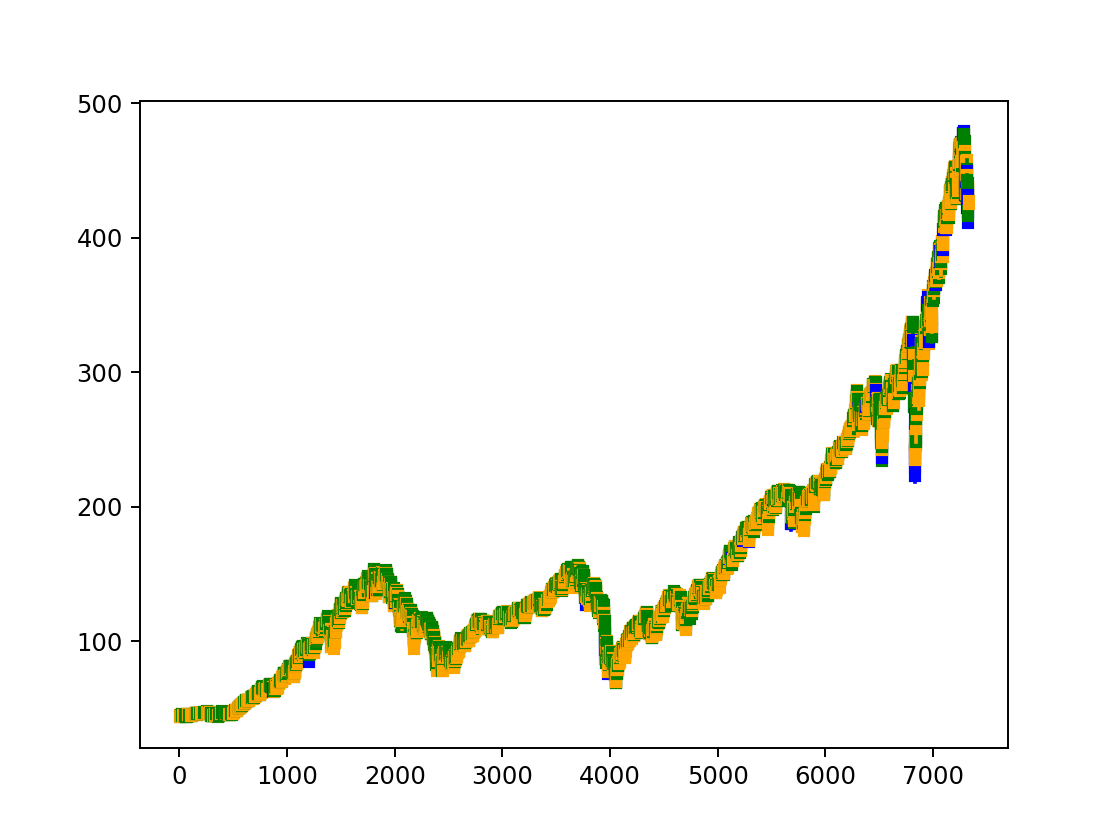

In [13]:
for d in range(spy.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_ocsvm[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['High'][d],spy['Low'][d]],color=c)
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<IPython.core.display.Javascript object>


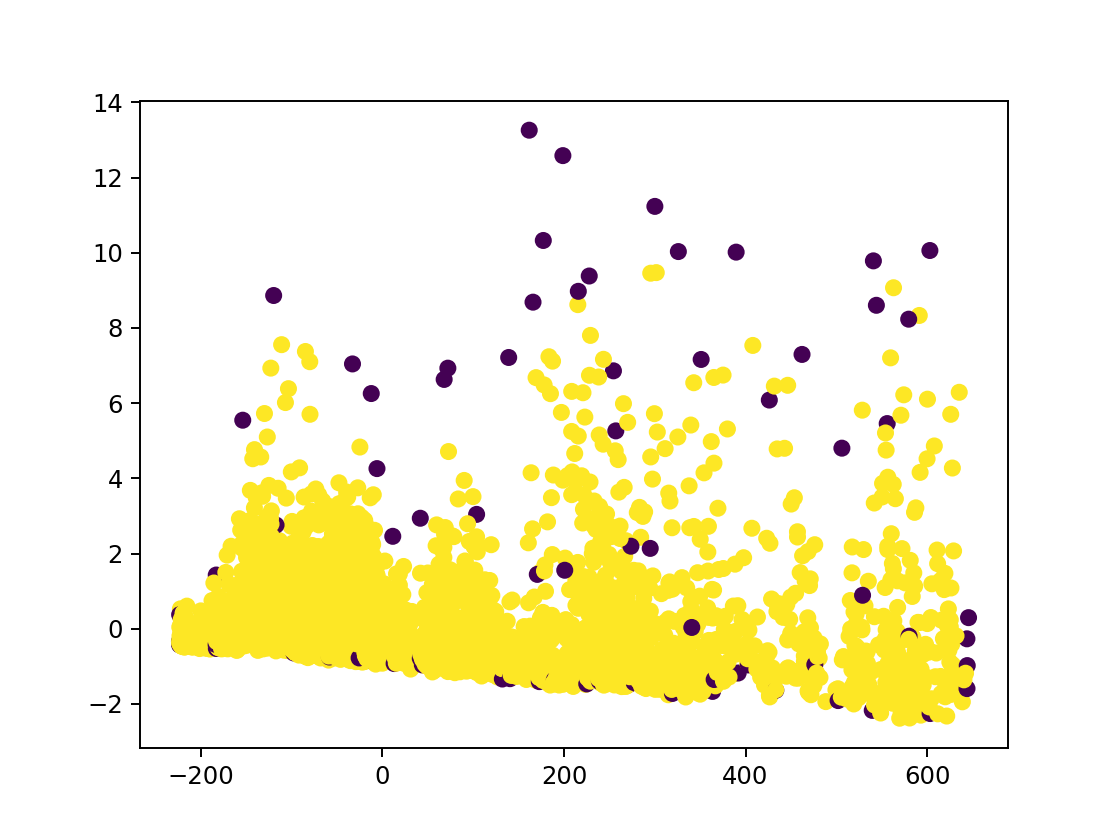

In [45]:
plt.scatter(X2d[:,0],X2d[:,1],c=y_ocsvm)
plt.show()

In [46]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, contamination=0.01).fit(X)
y_if = clf.predict(X)

<IPython.core.display.Javascript object>


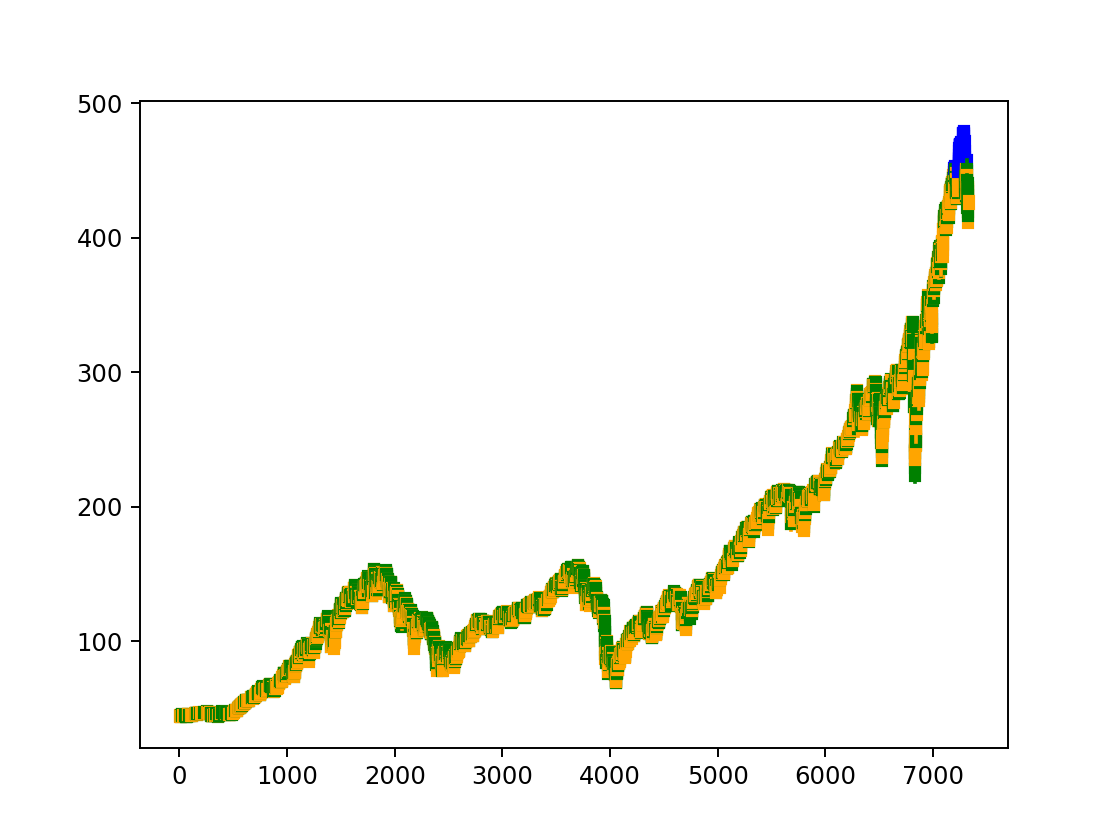

In [15]:
for d in range(spy.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_if[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['High'][d],spy['Low'][d]],color=c)
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<IPython.core.display.Javascript object>


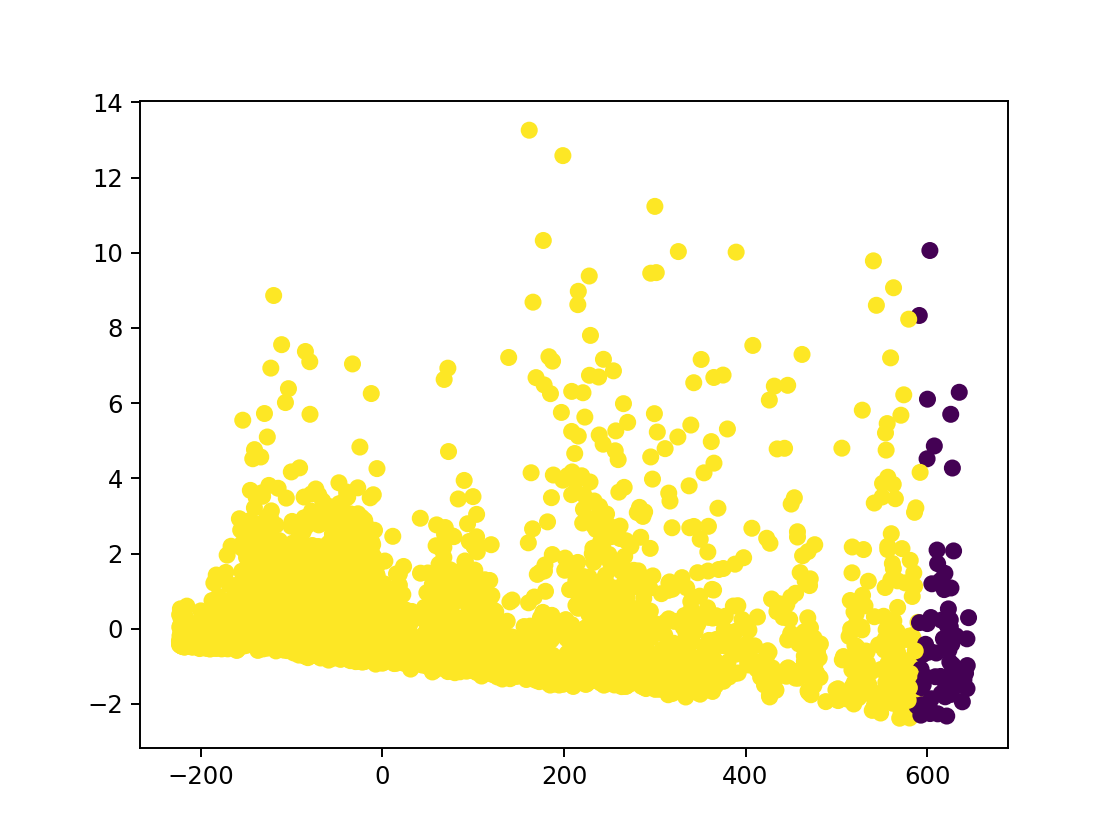

In [47]:
plt.scatter(X2d[:,0],X2d[:,1],c=y_if)
plt.show()

In [48]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=50)
y_lof = lof.fit_predict(X)

<IPython.core.display.Javascript object>


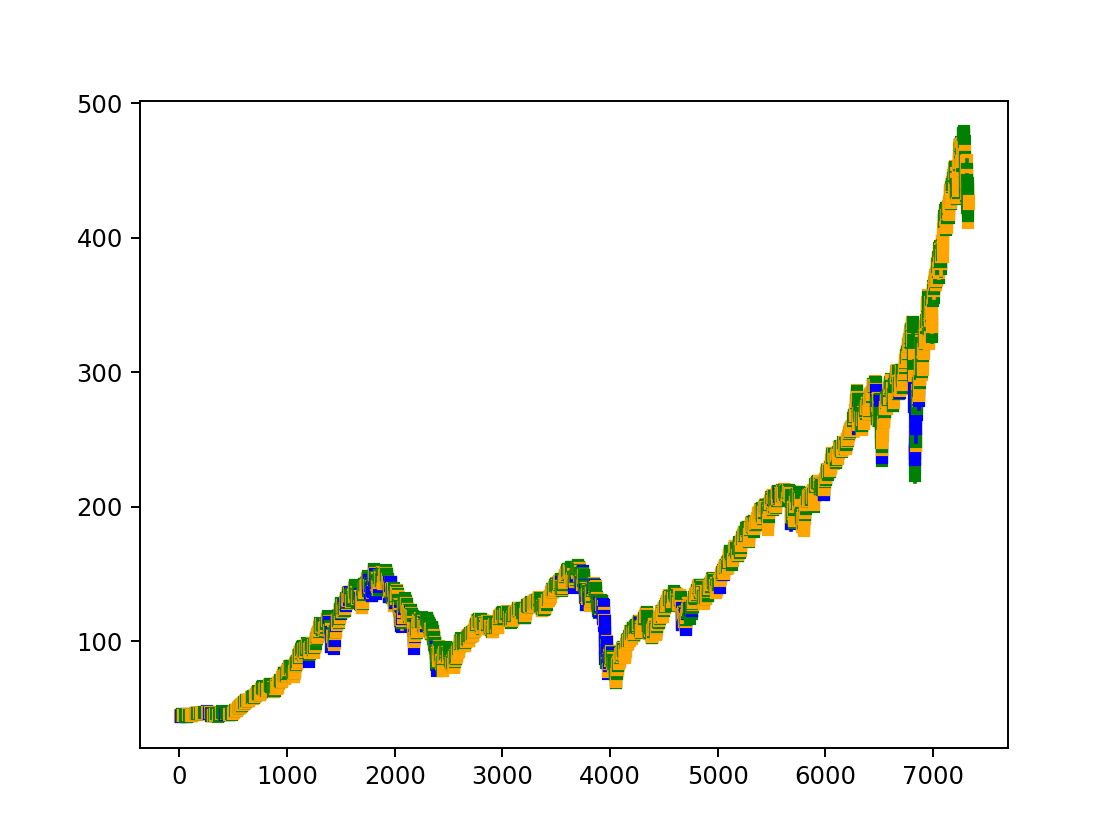

In [27]:
for d in range(spy.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_lof[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['High'][d],spy['Low'][d]],color=c)
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<IPython.core.display.Javascript object>


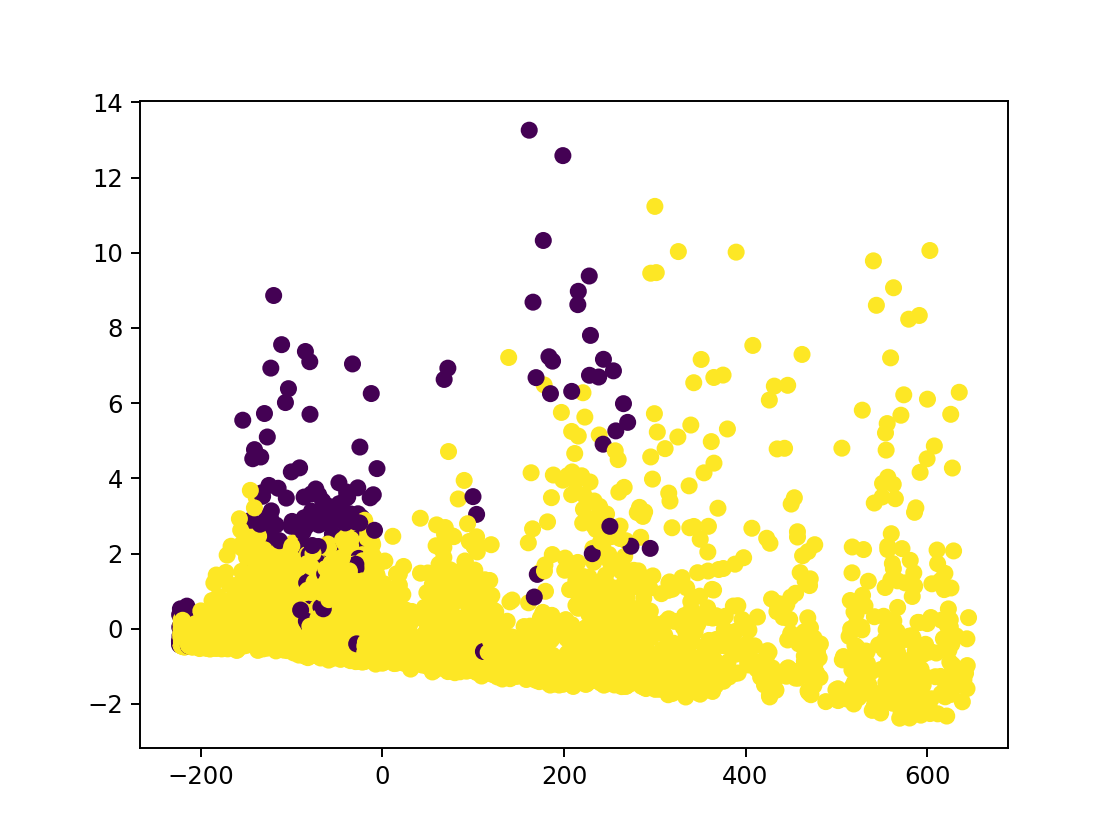

In [49]:
plt.scatter(X2d[:,0],X2d[:,1],c=y_lof)
plt.show()

<h5>Model the Differenced Data</h5>

In [29]:
X_diff = np.diff(X,axis=0)

In [50]:
pca = PCA(2)
X_diff_2d = pca.fit_transform(X_diff)

<IPython.core.display.Javascript object>


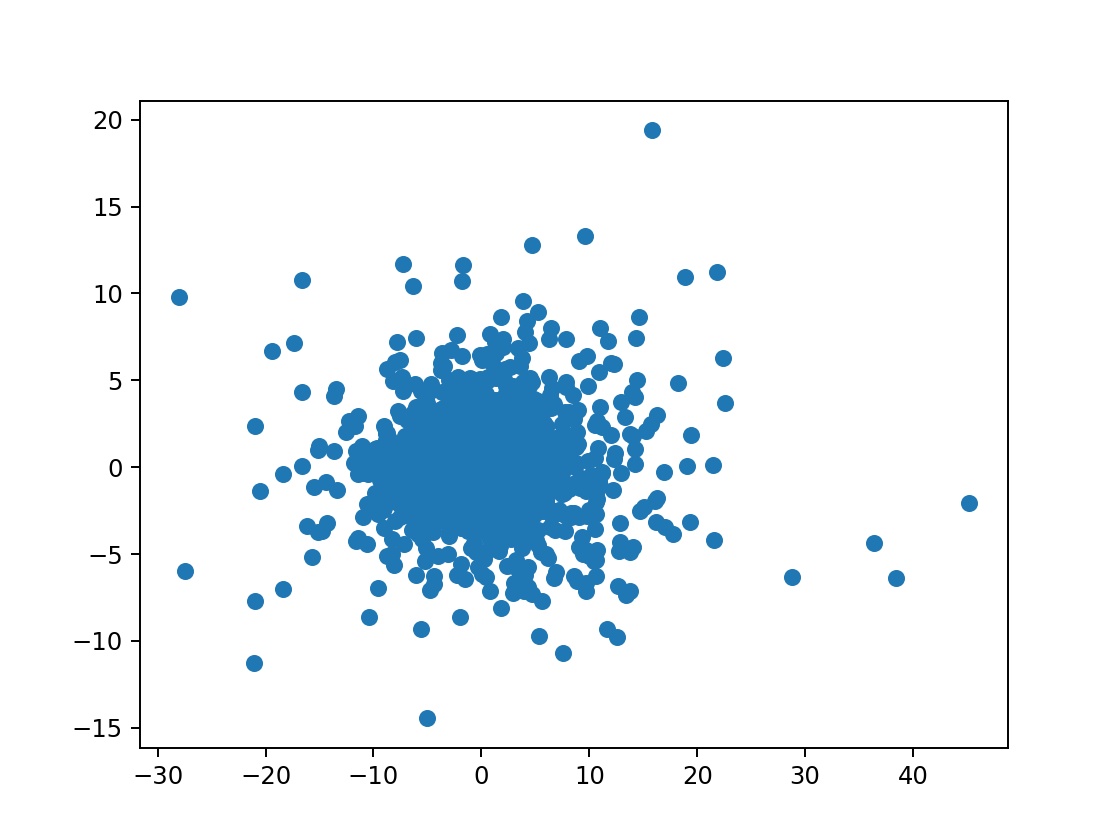

In [51]:
plt.scatter(X_diff_2d[:,0], X_diff_2d[:,1])
plt.show()

In [52]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(gamma=0.001,nu=0.01).fit(X_diff)
y_ocsvm = ocsvm.predict(X_diff)
np.unique(y_ocsvm, return_counts=True)

(array([-1,  1], dtype=int64), array([  74, 7256], dtype=int64))

<IPython.core.display.Javascript object>


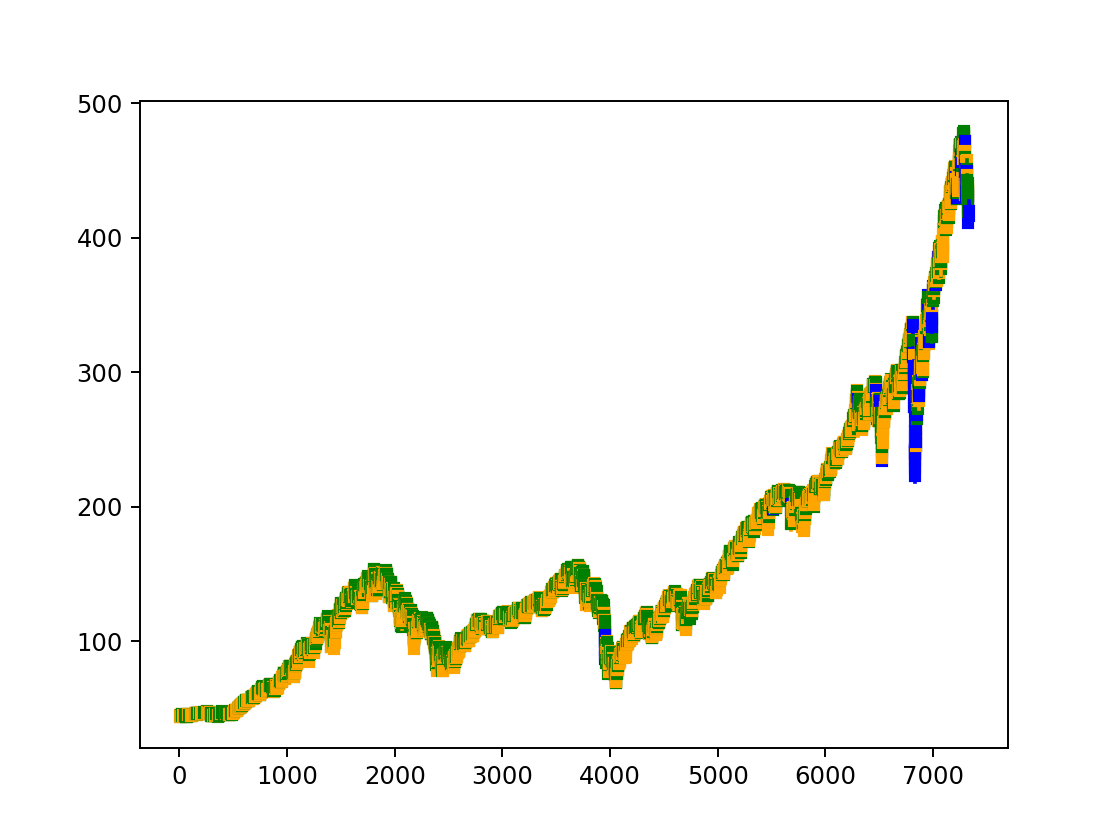

In [34]:
for d in range(X_diff.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_ocsvm[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['High'][d],spy['Low'][d]],color=c)
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<IPython.core.display.Javascript object>


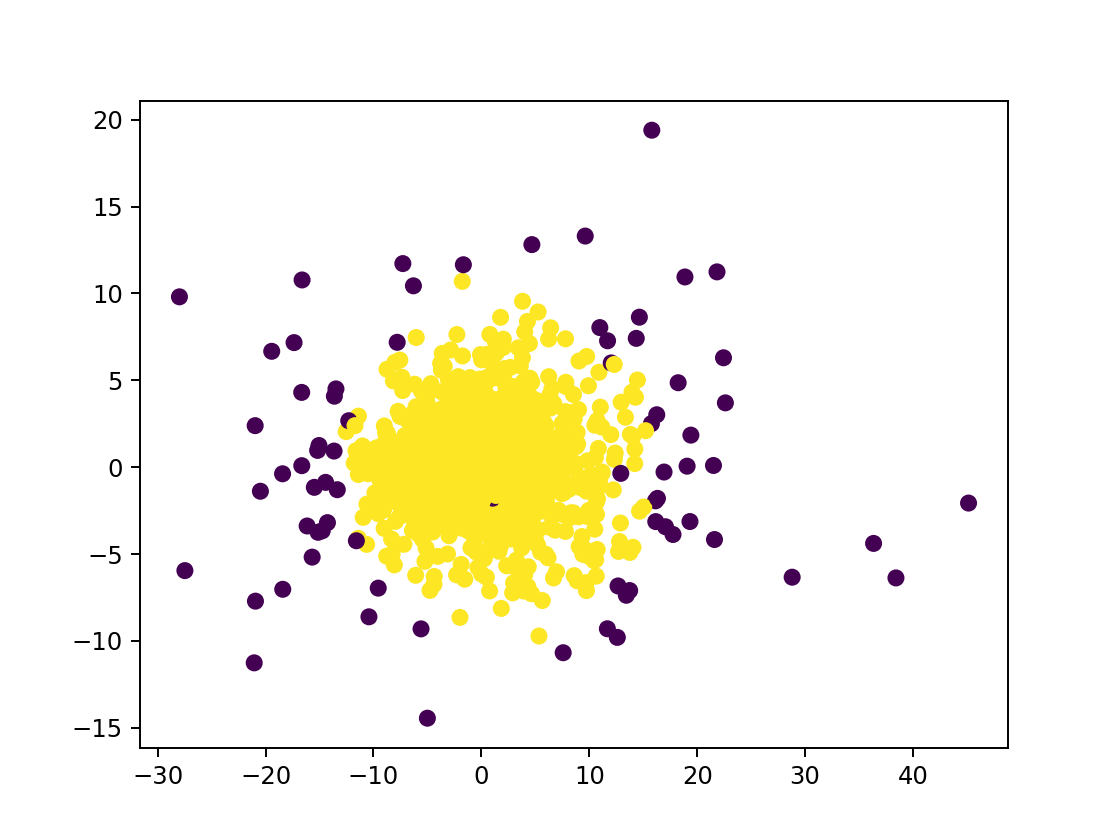

In [53]:
plt.scatter(X_diff_2d[:,0], X_diff_2d[:,1], c=y_ocsvm)
plt.show()

In [54]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, contamination=0.005).fit(X_diff)
y_if = clf.predict(X_diff)

<IPython.core.display.Javascript object>


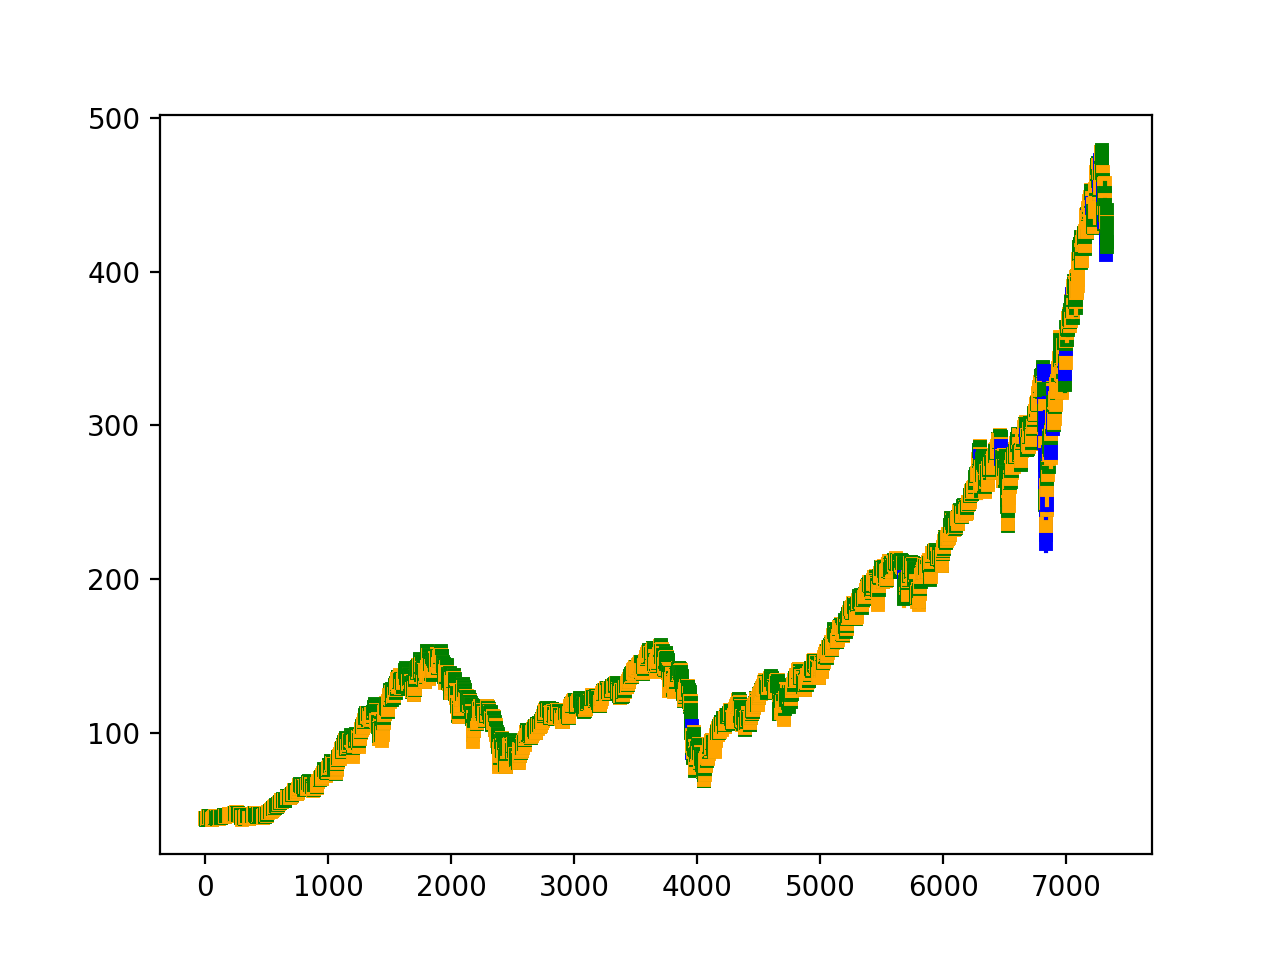

In [46]:
for d in range(X_diff.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_if[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['High'][d],spy['Low'][d]],color=c)
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<IPython.core.display.Javascript object>


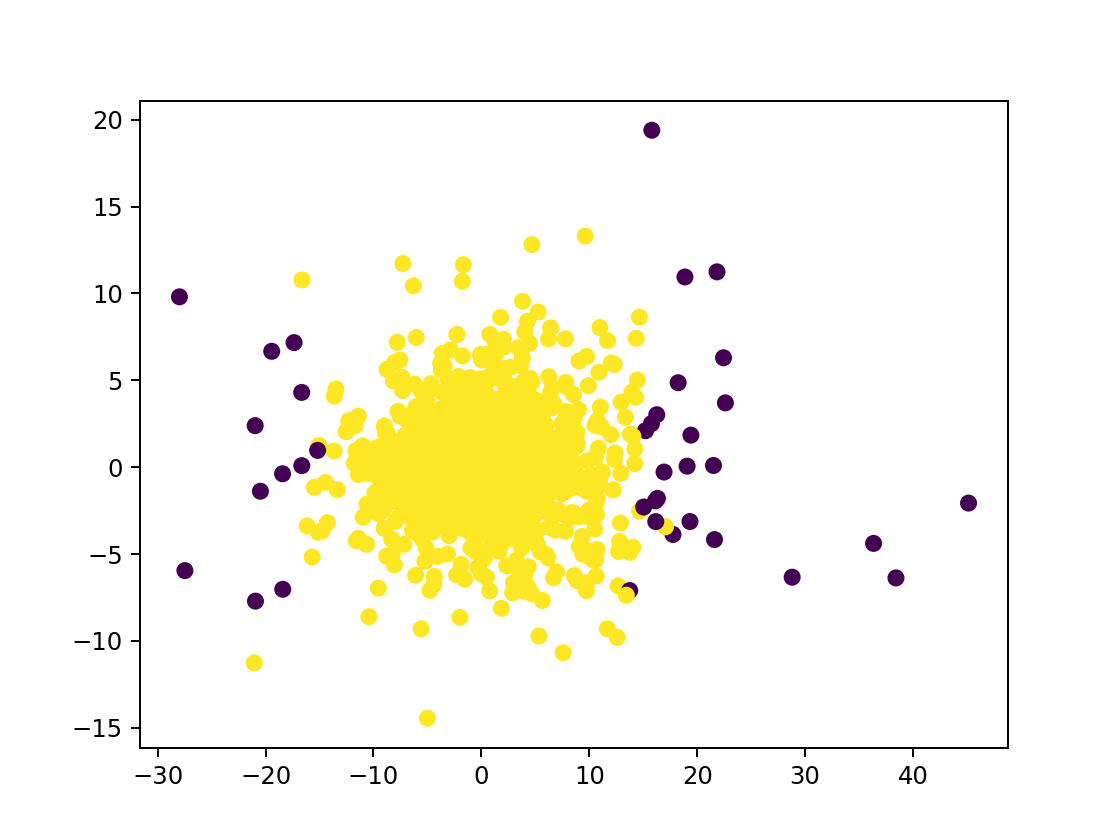

In [55]:
plt.scatter(X_diff_2d[:,0], X_diff_2d[:,1], c=y_if)
plt.show()

In [62]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20)
y_lof = lof.fit_predict(X_diff)

<IPython.core.display.Javascript object>


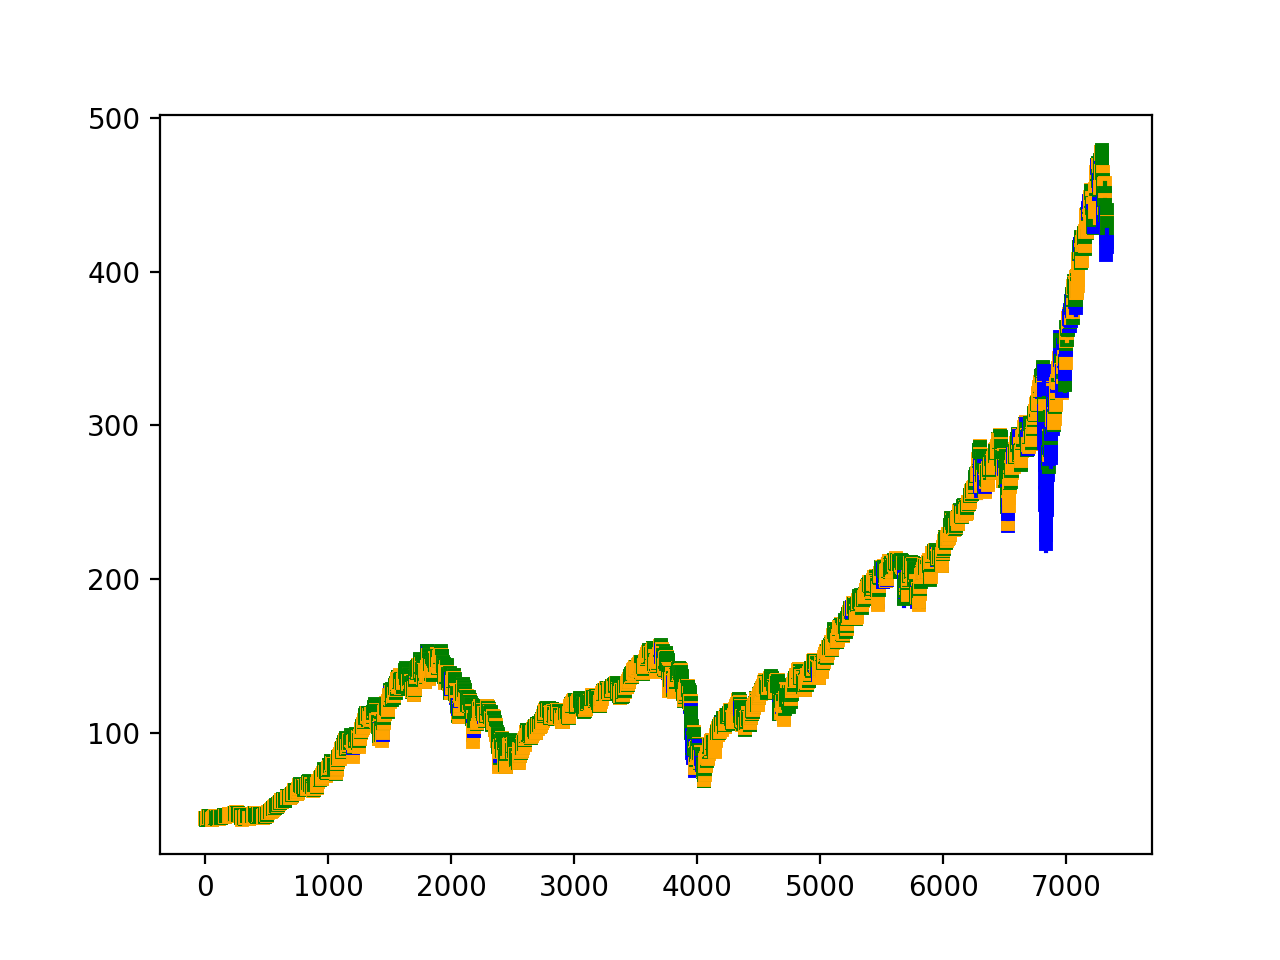

In [48]:
for d in range(X_diff.shape[0]):
    if spy['Open'][d] < spy['Close'][d]:
        c = 'orange'
    else:
        c = 'green'
    if y_lof[d] == -1:
        c = 'blue'
    plt.plot([d,d],[spy['High'][d],spy['Low'][d]],color=c)
    plt.plot([d,d],[spy['Open'][d],spy['Close'][d]],color=c,linewidth=5)
plt.show()

<IPython.core.display.Javascript object>


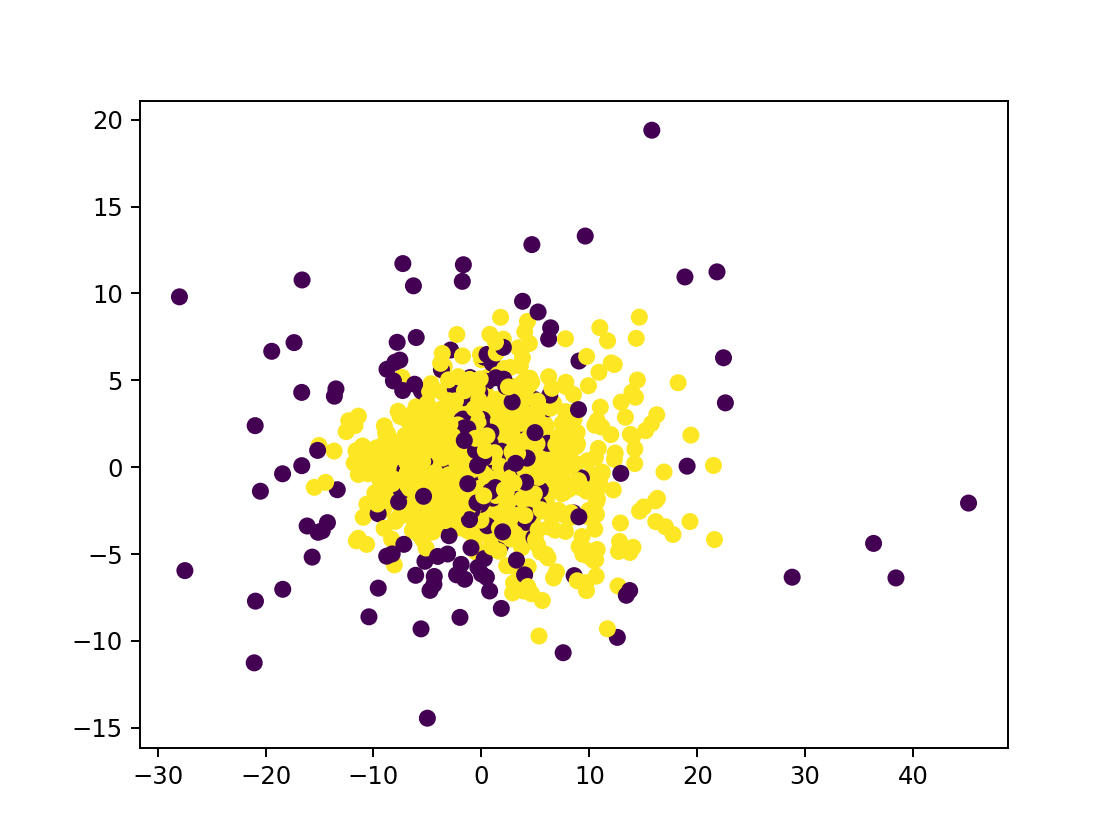

In [63]:
plt.scatter(X_diff_2d[:,0], X_diff_2d[:,1], c=y_lof)
plt.show()